## **KOH1: Podstawowa sieć Kohonena**

Zaimplementować sieć Kohonena złożoną z neuronów w prostokątnej siatce M×N (M,N są parametrami programu), która działa dla zbioru wektorów (wszystkich o tej samej długości).

Należy zaimplementować następujące funkcje sąsiedztwa:
- Funkcja gaussowska
- Minus druga pochodna funkcji gaussowskiej

W obu implementacjach dodać możliwość zmiany szerokości sąsiedztwa z użyciem parametru (technicznie oznacza to przemnożenie argumentu x przez stałą) i sprawdzić dla kilku wartości z przedziału [0.1, 10].

Jako funkcji wygaszającą uczenie wraz z kolejnymi iteracjami użyć funkcji
$$\alpha(t) = e^{-t/\lambda}$$

Przetestować działanie sieci na dostarczonych w kursie prostych zbiorach danych:
- danych 2d skupionych w wierzchołkach sześciokąta,
- danych 3d skupionych w wierzchołkach sześcianu.

Dane, odpowiednio hexagon i cube, mają 3 i 4 kolumny. Do sieci podać tylko kolumny x, y i z (w przypadku sześciokąta bez z). Ostatnia kolumna, c, zawiera identyfikator wierzchołka bryły/figury.

- Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych? (Tu potrzebny jest sposób ustalenia które podzbiory neuronów definiują klastry).
- Czy w obrębie pojedynczego neuronu znajdują się dane z tylko jednej klasy?
- Jakie są pozycje neuronów w danych?
- Jakie są liczności elementów z poszczególnych z klas w pojedynczym neuronie?

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

def gaussian_neighborhood(distance, sigma):
    return np.exp(-distance**2 / (2 * sigma**2))

def second_derivative_gaussian(distance, sigma):
    return -gaussian_neighborhood(distance, sigma) * (distance**2 - sigma**2) / sigma**4

class KohonenNetwork:
    def __init__(self, M, N, input_dim, learning_rate=0.1, neighborhood_function = 'gaussian', sigma=1.0, lambda_decay=1000):

        self.neighborhood_functions = {
            'gaussian': gaussian_neighborhood,
            'second_derivative_gaussian': second_derivative_gaussian,
        }

        self.neighborhood_function = self.neighborhood_functions[neighborhood_function]

        self.M, self.N = M, N
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.lambda_decay = lambda_decay
        self.weights = np.random.rand(M, N, input_dim)

    def decay_learning_rate(self, t):
        return np.exp(-t / self.lambda_decay)

    def find_bmu(self, input_vector):
        distances = np.linalg.norm(self.weights - input_vector, axis=2)
        bmu_index = np.unravel_index(np.argmin(distances), distances.shape)
        return bmu_index, distances

    def update_weights(self, input_vector, t):
        learning_rate = self.decay_learning_rate(t)
        bmu, distances = self.find_bmu(input_vector)
        
        for i in range(self.M):
            for j in range(self.N):
                distance = np.linalg.norm(np.array([i, j]) - np.array(bmu))
                influence = self.neighborhood_function(distance, self.sigma)
                self.weights[i, j] += learning_rate * influence * (input_vector - self.weights[i, j])

    def train(self, data, epochs):
        for t in range(epochs):
            input_vector = data[np.random.randint(0, data.shape[0])]
            self.update_weights(input_vector, t)

    def get_cluster_assignments(self, data):
        clusters = []
        for sample in data:
            bmu, _ = self.find_bmu(sample)
            cluster_number = bmu[0] * self.N + bmu[1]
            clusters.append(cluster_number)
        return np.array(clusters)

In [8]:
def accuracy_plot(X, y, preds):
    cluster_to_labels = defaultdict(list)
    for pred, label in zip(preds, y):
        cluster_to_labels[pred].append(label)

    mapping = {}
    for cluster, labels in cluster_to_labels.items():
        most_common_label = Counter(labels).most_common(1)[0][0]
        mapping[cluster] = most_common_label

    mapped_preds = np.array([mapping.get(p, -1) for p in preds])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=30)
    plt.title("Prawdziwe klasy")
    plt.xlabel("X1")
    plt.ylabel("X2")

    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=mapped_preds, cmap='tab10', s=30)
    plt.title("Przypisane klastry (dopasowane)")
    plt.xlabel("X1")
    plt.ylabel("X2")

    plt.tight_layout()
    plt.show()

    accuracy = np.mean(mapped_preds == y)
    print("Dopasowana accuracy:", accuracy)

def analyze_clusters(network, data, y_true):
    unique_clusters = np.unique(network.get_cluster_assignments(data))
    unique_classes = np.unique(y_true)

    print(f"Liczba klastrów: {len(unique_clusters)}")
    print(f"Liczba klas: {len(unique_classes)}")

    if len(unique_clusters) == len(unique_classes):
        print("Liczba klastrów pokrywa się z liczbą klas.")
    else:
        print("Liczba klastrów nie pokrywa się z liczbą klas.")
    
    cluster_to_labels = defaultdict(list)
    for i, pred in enumerate(network.get_cluster_assignments(data)):
        cluster_to_labels[pred].append(y_true[i])

    print("\nAnaliza klastrów:")
    for cluster, labels in cluster_to_labels.items():
        class_counts = Counter(labels)
        if len(class_counts) == 1:
            most_common_class = list(class_counts.keys())[0]
            print(f"Klaster {cluster} zawiera dane tylko z jednej klasy ({most_common_class}) i występuje {class_counts[most_common_class]} razy.")
        else:
            print(f"Klaster {cluster} zawiera dane z różnych klas: {dict(class_counts)}")

    print("\nPozycje neuronów (indeksy klastrów w przestrzeni danych):")
    positions = np.array([np.unravel_index(cluster, (network.M, network.N)) for cluster in unique_clusters])
    print(positions)

In [ ]:
def plot_cluster_class_distribution(network, data, y_true):

    preds = network.get_cluster_assignments(data)
    cluster_to_labels = defaultdict(list)

    for pred, label in zip(preds, y_true):
        cluster_to_labels[pred].append(label)

    sorted_clusters = sorted(cluster_to_labels.keys())
    x = np.arange(len(sorted_clusters))

    cluster_class_counts_sorted = []
    for cluster in sorted_clusters:
        counts = Counter(cluster_to_labels[cluster])
        sorted_items = counts.most_common()
        cluster_class_counts_sorted.append(sorted_items)

    all_classes = sorted(set(y_true))

    cmap = plt.get_cmap("tab10")
    color_map = {cls: cmap(i % 10) for i, cls in enumerate(all_classes)}

    plt.figure(figsize=(10, 8))
    bottoms = np.zeros(len(sorted_clusters))

    max_depth = max(len(c) for c in cluster_class_counts_sorted)

    for level in range(max_depth):
        heights = []
        labels = []
        for c in cluster_class_counts_sorted:
            if level < len(c):
                cls, count = c[level]
                heights.append(count)
                labels.append(cls)
            else:
                heights.append(0)
                labels.append(None)

        for cls in set(l for l in labels if l is not None):
            h = [heights[i] if labels[i] == cls else 0 for i in range(len(labels))]
            plt.bar(x, h, bottom=bottoms, color=color_map[cls], label=f"Klasa {cls}" if level == 0 else "", edgecolor='black', linewidth=0.3)
            bottoms += h

    plt.xticks(x, sorted_clusters)
    plt.xlabel("Numer klastra (neuronu)")
    plt.ylabel("Liczba próbek")
    plt.title("Skumulowany rozkład klas w klastrach (najczęstsze klasy na dole)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title="Klasy")
    plt.tight_layout()
    plt.show()


### Zbiór hexagon

#### funkcja gaussowska

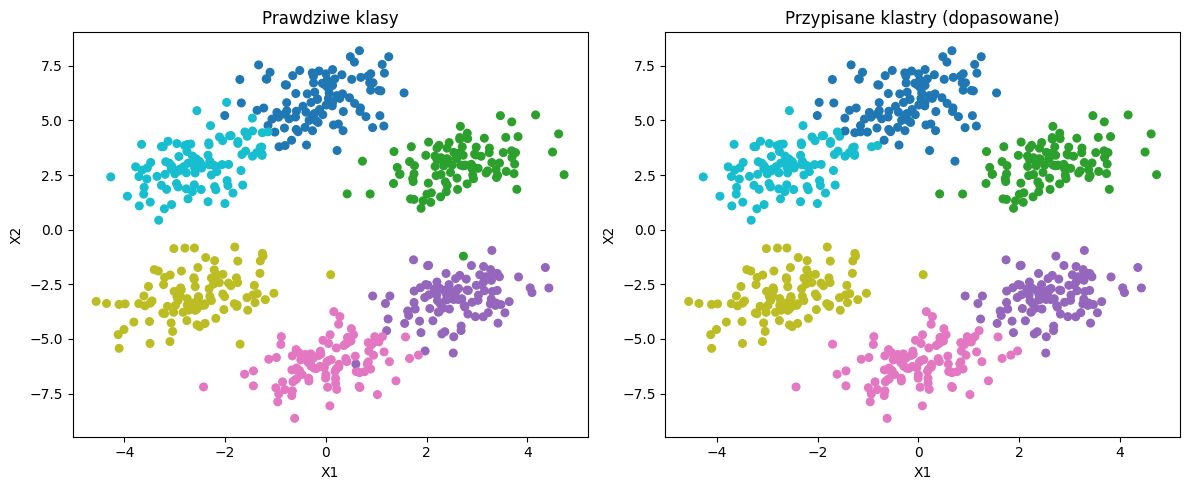

Dopasowana accuracy: 0.9783333333333334
Liczba klastrów: 92
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 49 zawiera dane tylko z jednej klasy (1) i występuje 8 razy.
Klaster 98 zawiera dane tylko z jednej klasy (0) i występuje 12 razy.
Klaster 35 zawiera dane tylko z jednej klasy (2) i występuje 5 razy.
Klaster 18 zawiera dane tylko z jednej klasy (1) i występuje 7 razy.
Klaster 6 zawiera dane tylko z jednej klasy (2) i występuje 11 razy.
Klaster 34 zawiera dane tylko z jednej klasy (2) i występuje 8 razy.
Klaster 38 zawiera dane tylko z jednej klasy (1) i występuje 6 razy.
Klaster 50 zawiera dane tylko z jednej klasy (4) i występuje 9 razy.
Klaster 87 zawiera dane z różnych klas: {0: 4, 5: 1}
Klaster 52 zawiera dane tylko z jednej klasy (4) i występuje 3 razy.
Klaster 78 zawiera dane tylko z jednej klasy (0) i występuje 9 razy.
Klaster 16 zawiera dane z różnych klas: {2: 3, 1: 1}
Klaster 1 zawiera dane tylko z jednej klasy (3) i występuje 6 

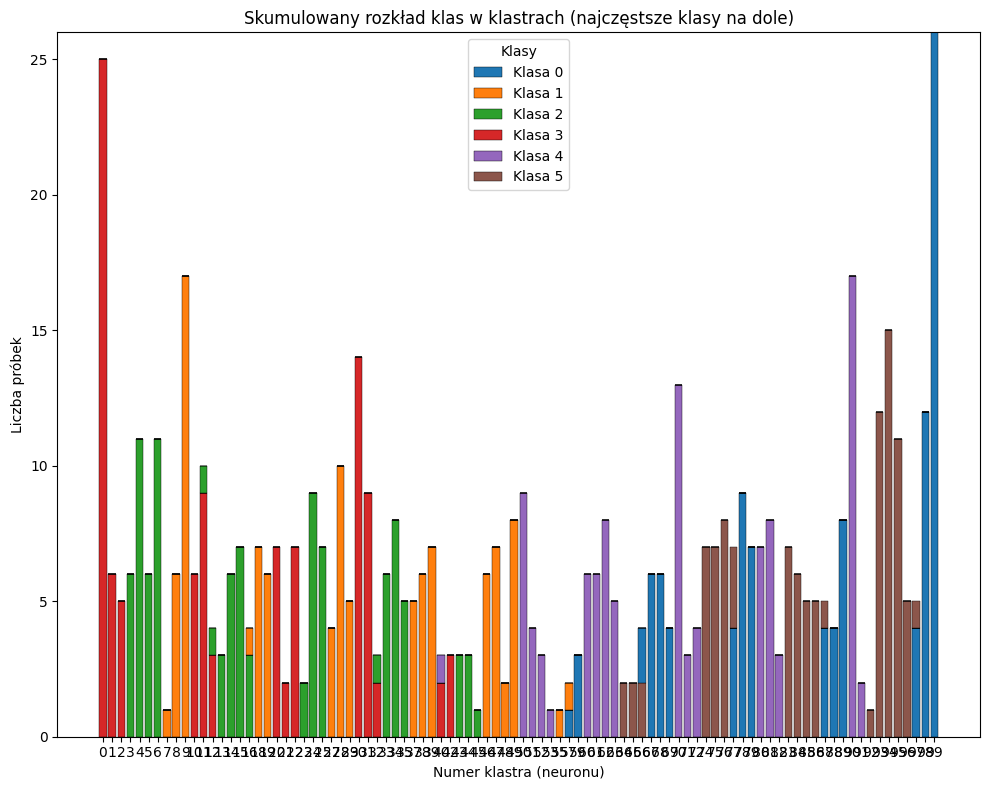

In [ ]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=2)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

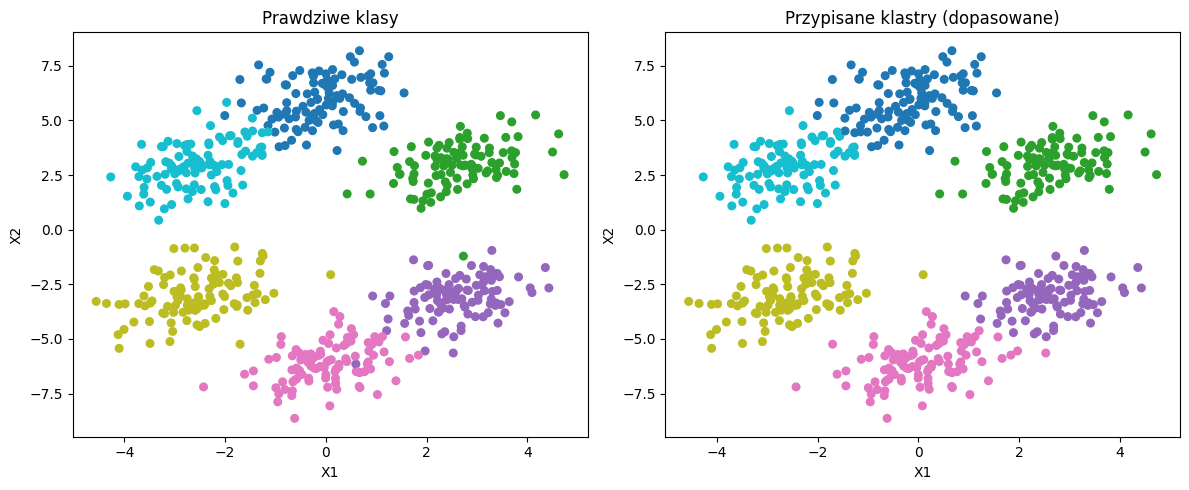

Dopasowana accuracy: 0.9816666666666667
Liczba klastrów: 17
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 43 zawiera dane tylko z jednej klasy (1) i występuje 26 razy.
Klaster 19 zawiera dane tylko z jednej klasy (0) i występuje 53 razy.
Klaster 49 zawiera dane z różnych klas: {2: 48, 1: 1}
Klaster 14 zawiera dane tylko z jednej klasy (1) i występuje 22 razy.
Klaster 33 zawiera dane tylko z jednej klasy (1) i występuje 38 razy.
Klaster 38 zawiera dane tylko z jednej klasy (4) i występuje 37 razy.
Klaster 11 zawiera dane z różnych klas: {0: 47, 5: 5}
Klaster 5 zawiera dane tylko z jednej klasy (4) i występuje 40 razy.
Klaster 7 zawiera dane z różnych klas: {3: 58, 4: 1}
Klaster 17 zawiera dane z różnych klas: {3: 42, 2: 4}
Klaster 46 zawiera dane tylko z jednej klasy (5) i występuje 43 razy.
Klaster 40 zawiera dane tylko z jednej klasy (2) i występuje 48 razy.
Klaster 16 zawiera dane tylko z jednej klasy (5) i występuje 52 razy.
Klaster 12 zawi

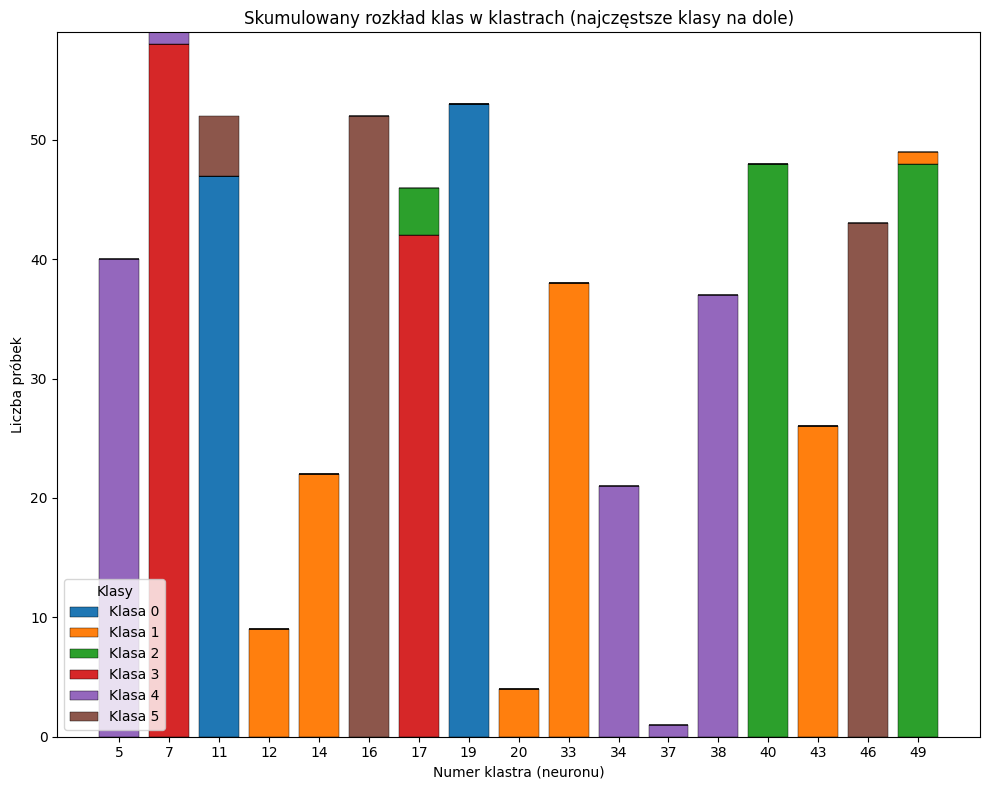

In [63]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=5, input_dim=2, sigma=0.1)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

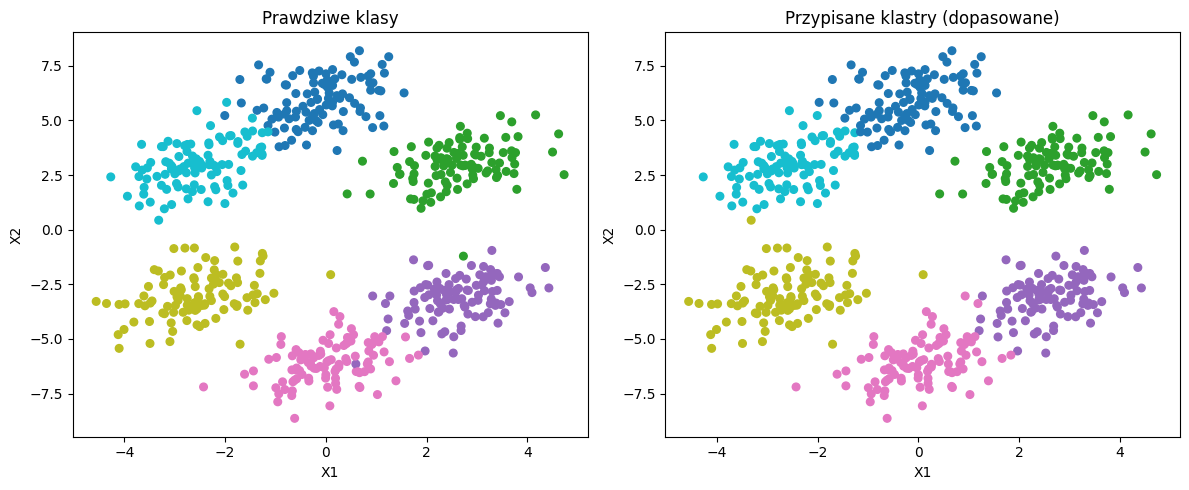

Dopasowana accuracy: 0.9833333333333333
Liczba klastrów: 49
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 34 zawiera dane tylko z jednej klasy (1) i występuje 36 razy.
Klaster 49 zawiera dane tylko z jednej klasy (0) i występuje 31 razy.
Klaster 18 zawiera dane tylko z jednej klasy (2) i występuje 7 razy.
Klaster 29 zawiera dane tylko z jednej klasy (1) i występuje 26 razy.
Klaster 19 zawiera dane z różnych klas: {2: 19, 1: 1}
Klaster 13 zawiera dane tylko z jednej klasy (2) i występuje 12 razy.
Klaster 33 zawiera dane tylko z jednej klasy (1) i występuje 9 razy.
Klaster 10 zawiera dane tylko z jednej klasy (4) i występuje 9 razy.
Klaster 47 zawiera dane z różnych klas: {0: 13, 5: 2}
Klaster 17 zawiera dane tylko z jednej klasy (4) i występuje 2 razy.
Klaster 43 zawiera dane tylko z jednej klasy (0) i występuje 12 razy.
Klaster 1 zawiera dane z różnych klas: {3: 19, 2: 1}
Klaster 2 zawiera dane tylko z jednej klasy (3) i występuje 16 razy.
Kla

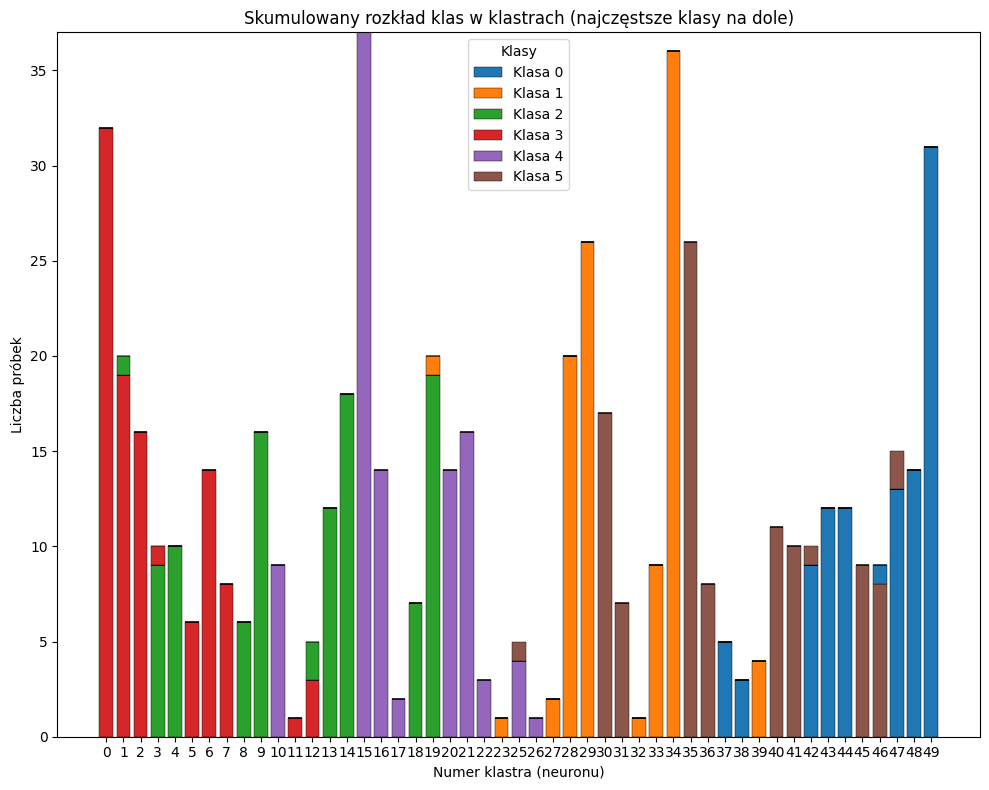

In [39]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=5, input_dim=2)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

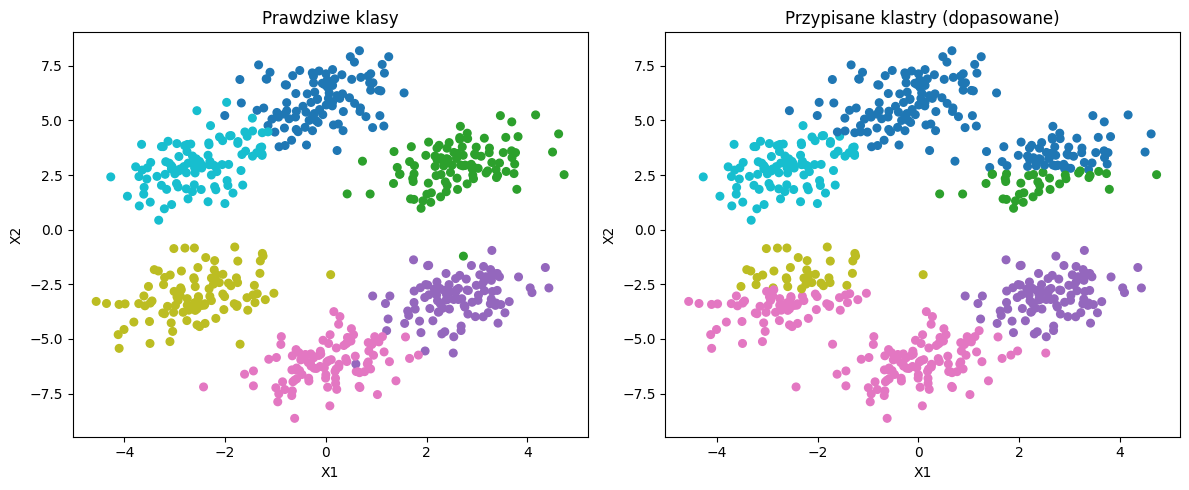

Dopasowana accuracy: 0.77
Liczba klastrów: 24
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 45 zawiera dane z różnych klas: {1: 63, 0: 100, 5: 7}
Klaster 0 zawiera dane tylko z jednej klasy (2) i występuje 71 razy.
Klaster 40 zawiera dane tylko z jednej klasy (1) i występuje 18 razy.
Klaster 4 zawiera dane z różnych klas: {4: 63, 3: 100, 2: 4}
Klaster 10 zawiera dane z różnych klas: {2: 2, 1: 1}
Klaster 49 zawiera dane tylko z jednej klasy (5) i występuje 61 razy.
Klaster 30 zawiera dane tylko z jednej klasy (1) i występuje 6 razy.
Klaster 14 zawiera dane tylko z jednej klasy (4) i występuje 14 razy.
Klaster 9 zawiera dane tylko z jednej klasy (4) i występuje 12 razy.
Klaster 1 zawiera dane tylko z jednej klasy (2) i występuje 5 razy.
Klaster 44 zawiera dane tylko z jednej klasy (5) i występuje 11 razy.
Klaster 5 zawiera dane tylko z jednej klasy (2) i występuje 11 razy.
Klaster 47 zawiera dane tylko z jednej klasy (5) i występuje 5 razy.
Klas

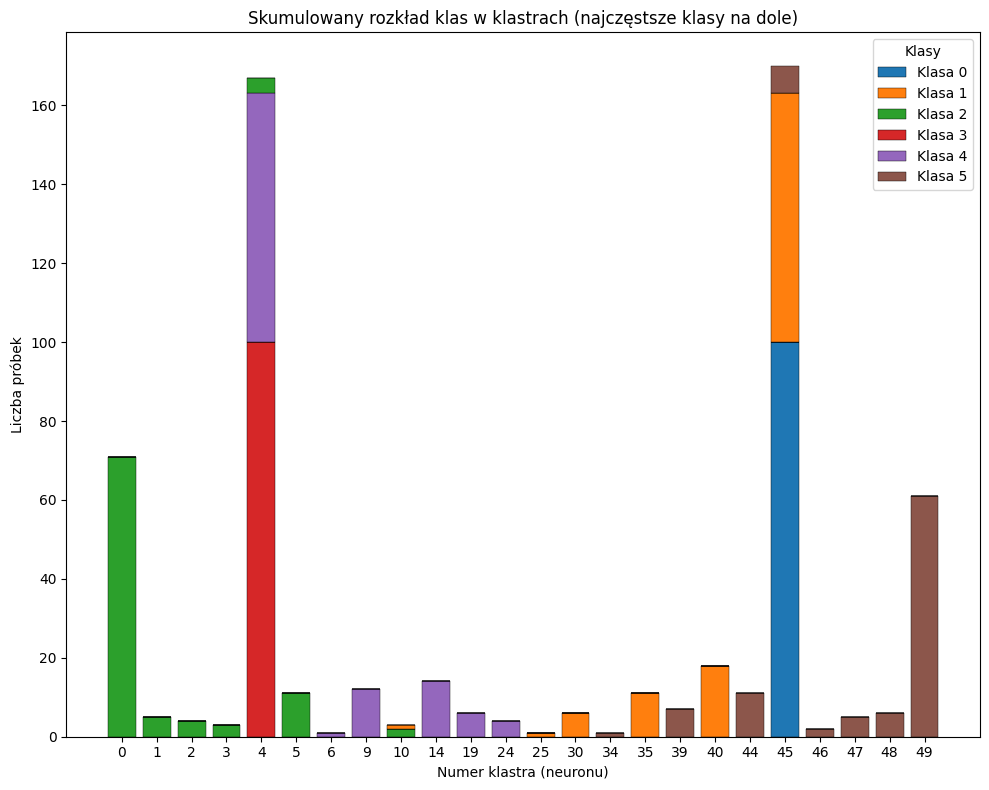

In [65]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=5, input_dim=2, sigma=5)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

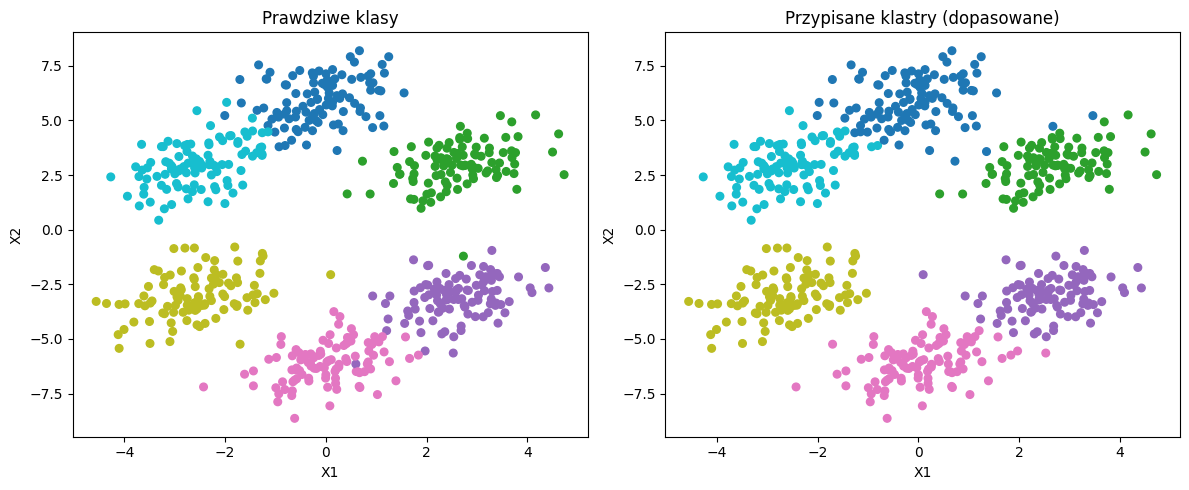

Dopasowana accuracy: 0.9716666666666667
Liczba klastrów: 23
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 10 zawiera dane tylko z jednej klasy (1) i występuje 67 razy.
Klaster 20 zawiera dane tylko z jednej klasy (0) i występuje 62 razy.
Klaster 1 zawiera dane tylko z jednej klasy (2) i występuje 50 razy.
Klaster 14 zawiera dane tylko z jednej klasy (4) i występuje 61 razy.
Klaster 21 zawiera dane z różnych klas: {0: 27, 5: 4}
Klaster 13 zawiera dane tylko z jednej klasy (4) i występuje 19 razy.
Klaster 0 zawiera dane z różnych klas: {2: 8, 1: 1}
Klaster 4 zawiera dane z różnych klas: {3: 74, 2: 1}
Klaster 3 zawiera dane z różnych klas: {3: 20, 2: 3}
Klaster 23 zawiera dane tylko z jednej klasy (5) i występuje 44 razy.
Klaster 2 zawiera dane tylko z jednej klasy (2) i występuje 32 razy.
Klaster 5 zawiera dane tylko z jednej klasy (1) i występuje 9 razy.
Klaster 22 zawiera dane z różnych klas: {5: 41, 0: 2}
Klaster 15 zawiera dane z różnych kla

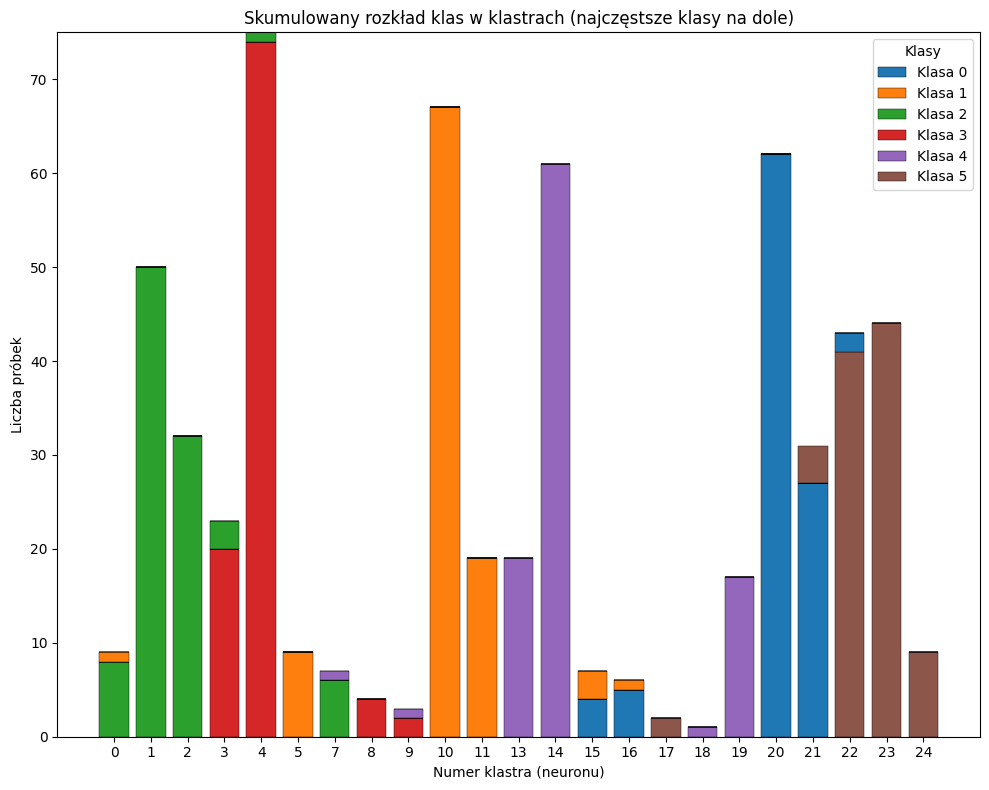

In [40]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=5, N=5, input_dim=2)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

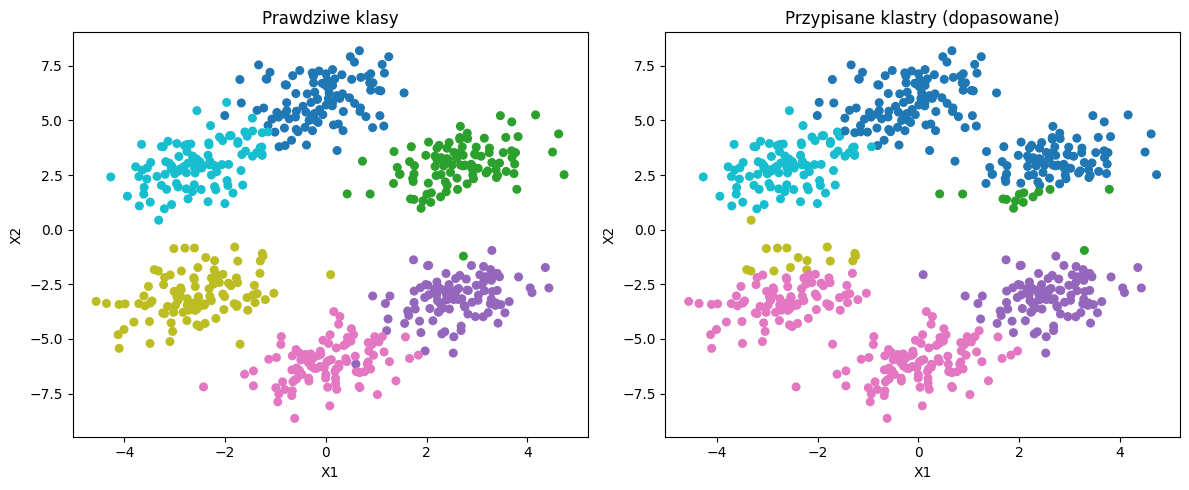

Dopasowana accuracy: 0.695
Liczba klastrów: 6
Liczba klas: 6
Liczba klastrów pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 3 zawiera dane z różnych klas: {1: 86, 0: 99, 5: 5}
Klaster 5 zawiera dane z różnych klas: {2: 96, 4: 1, 1: 1}
Klaster 2 zawiera dane z różnych klas: {4: 84, 3: 100, 2: 3}
Klaster 4 zawiera dane z różnych klas: {2: 1, 1: 13}
Klaster 0 zawiera dane z różnych klas: {5: 94, 0: 1}
Klaster 1 zawiera dane z różnych klas: {4: 15, 5: 1}

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]]


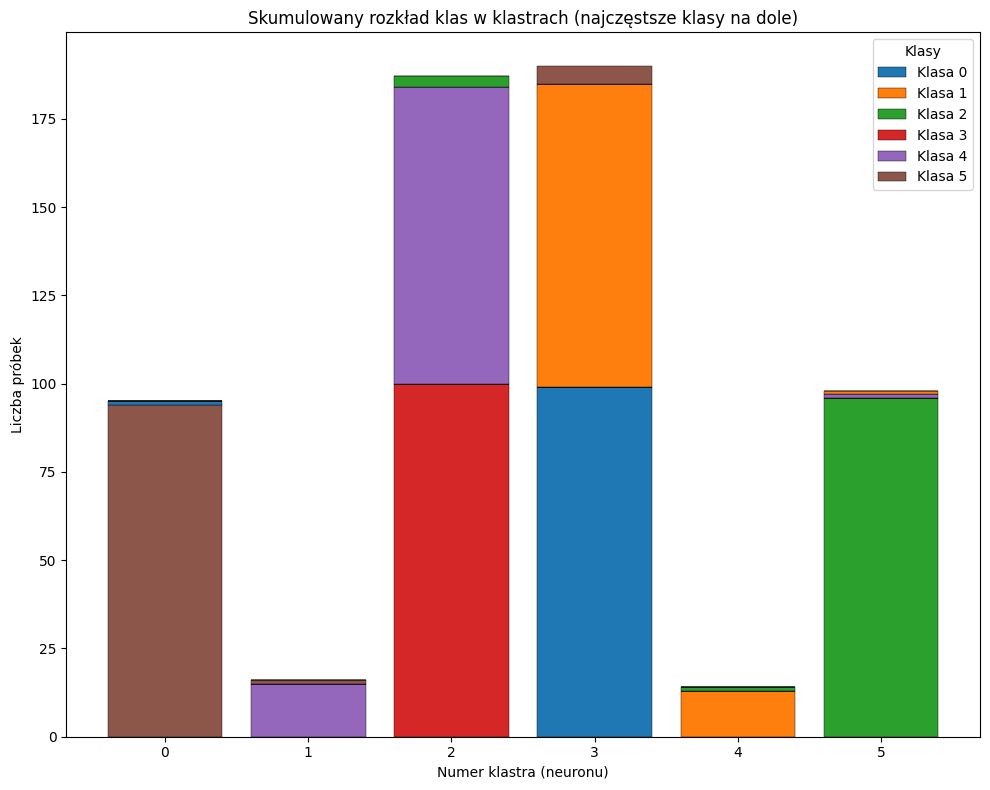

In [45]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=2, N=3, input_dim=2)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

| **Zbiór**       | **Rozmiar siatki** | **Szerokość sąsiedztwa** | **Liczba klastrów** | **Dokładność** |
|-----------------|------------------|------------------|-------------------|-------------|
| Heksagon - Gauss | 10×10            | 1                | 92               | 0.9783      |
| Heksagon - Gauss | 10×5             | 5                | 24               | 0.77        |
| Heksagon - Gauss | 10×5             | 1                | 49               | 0.9833      |
| Heksagon - Gauss | 10×5             | 0.1              | 5                | 0.9817      |
| Heksagon - Gauss | 5×5              | 1                | 23               | 0.9717      |
| Heksagon - Gauss | 2×3              | 1                | 6                | 0.695       |

#### minus druga pochodna funkcji gaussowskiej

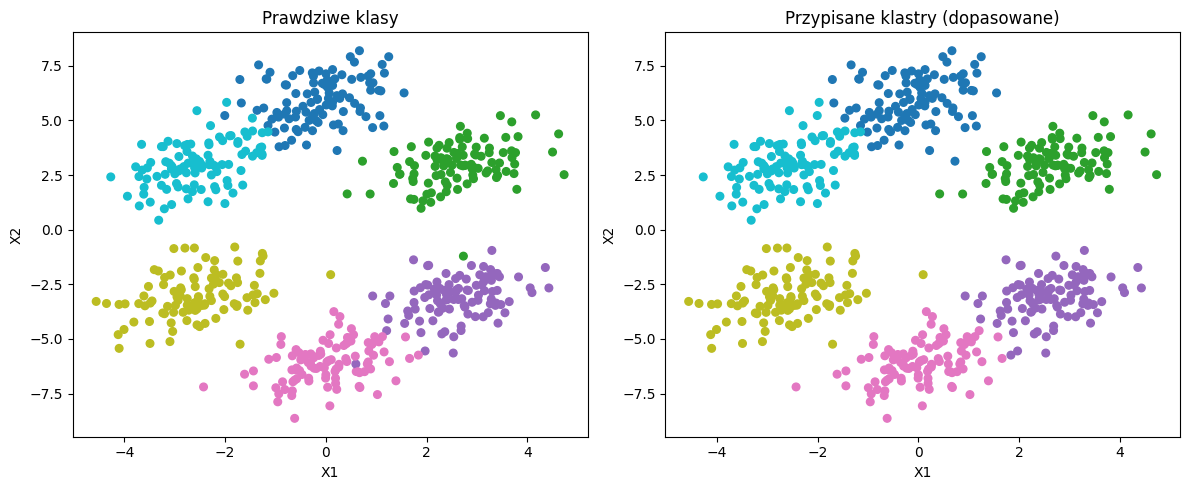

Dopasowana accuracy: 0.9883333333333333
Liczba klastrów: 108
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 265 zawiera dane tylko z jednej klasy (1) i występuje 9 razy.
Klaster 162 zawiera dane tylko z jednej klasy (0) i występuje 4 razy.
Klaster 252 zawiera dane tylko z jednej klasy (2) i występuje 13 razy.
Klaster 287 zawiera dane tylko z jednej klasy (1) i występuje 15 razy.
Klaster 272 zawiera dane tylko z jednej klasy (2) i występuje 21 razy.
Klaster 266 zawiera dane tylko z jednej klasy (1) i występuje 11 razy.
Klaster 72 zawiera dane tylko z jednej klasy (4) i występuje 4 razy.
Klaster 143 zawiera dane tylko z jednej klasy (0) i występuje 8 razy.
Klaster 111 zawiera dane tylko z jednej klasy (4) i występuje 2 razy.
Klaster 183 zawiera dane tylko z jednej klasy (0) i występuje 13 razy.
Klaster 291 zawiera dane tylko z jednej klasy (2) i występuje 8 razy.
Klaster 175 zawiera dane z różnych klas: {3: 9, 2: 1}
Klaster 174 zawiera dane tylko

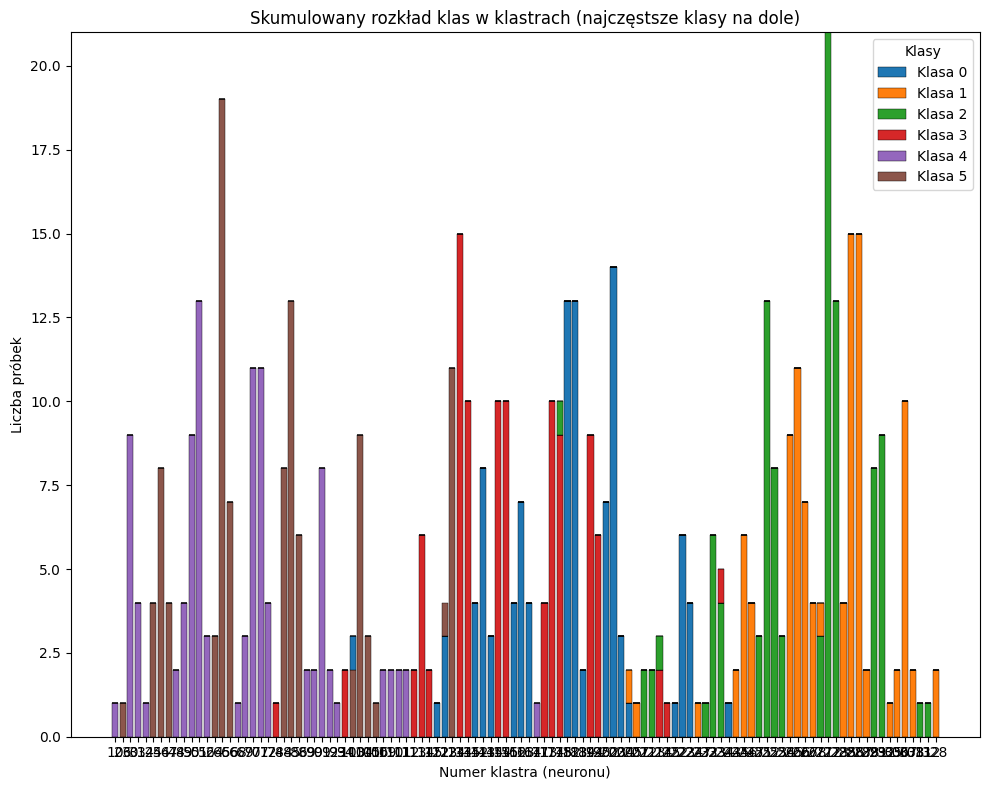

In [66]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=20, N=20, input_dim=2, neighborhood_function='second_derivative_gaussian', sigma=10)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

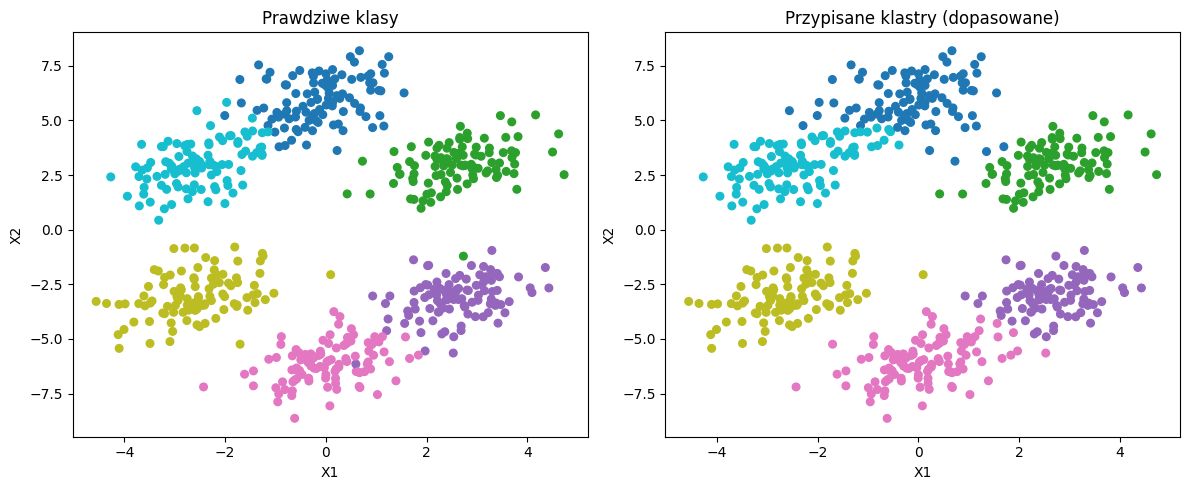

Dopasowana accuracy: 0.96
Liczba klastrów: 22
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 380 zawiera dane tylko z jednej klasy (1) i występuje 61 razy.
Klaster 199 zawiera dane tylko z jednej klasy (0) i występuje 25 razy.
Klaster 325 zawiera dane tylko z jednej klasy (2) i występuje 39 razy.
Klaster 305 zawiera dane z różnych klas: {2: 26, 1: 1}
Klaster 300 zawiera dane tylko z jednej klasy (1) i występuje 30 razy.
Klaster 201 zawiera dane tylko z jednej klasy (4) i występuje 13 razy.
Klaster 6 zawiera dane z różnych klas: {0: 11, 5: 4}
Klaster 338 zawiera dane tylko z jednej klasy (4) i występuje 25 razy.
Klaster 101 zawiera dane tylko z jednej klasy (0) i występuje 30 razy.
Klaster 295 zawiera dane z różnych klas: {3: 27, 2: 1}
Klaster 5 zawiera dane z różnych klas: {3: 32, 2: 6}
Klaster 79 zawiera dane tylko z jednej klasy (5) i występuje 17 razy.
Klaster 14 zawiera dane tylko z jednej klasy (2) i występuje 28 razy.
Klaster 339 zawiera 

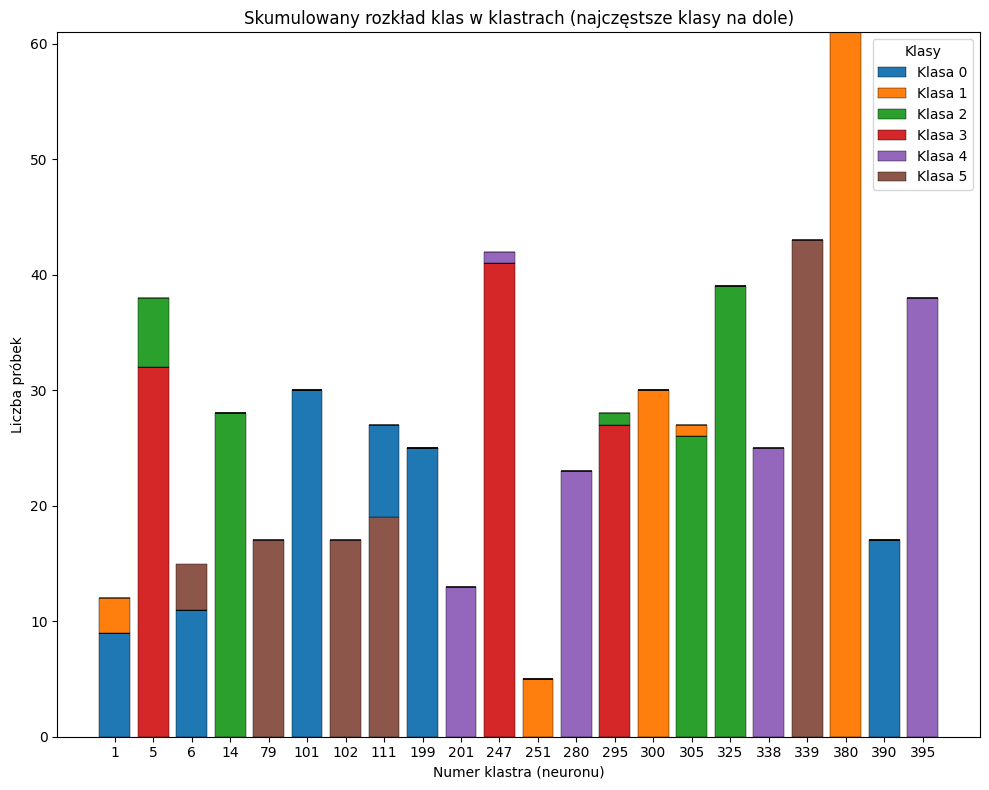

In [ ]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=20, N=20, input_dim=2, neighborhood_function='second_derivative_gaussian')

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

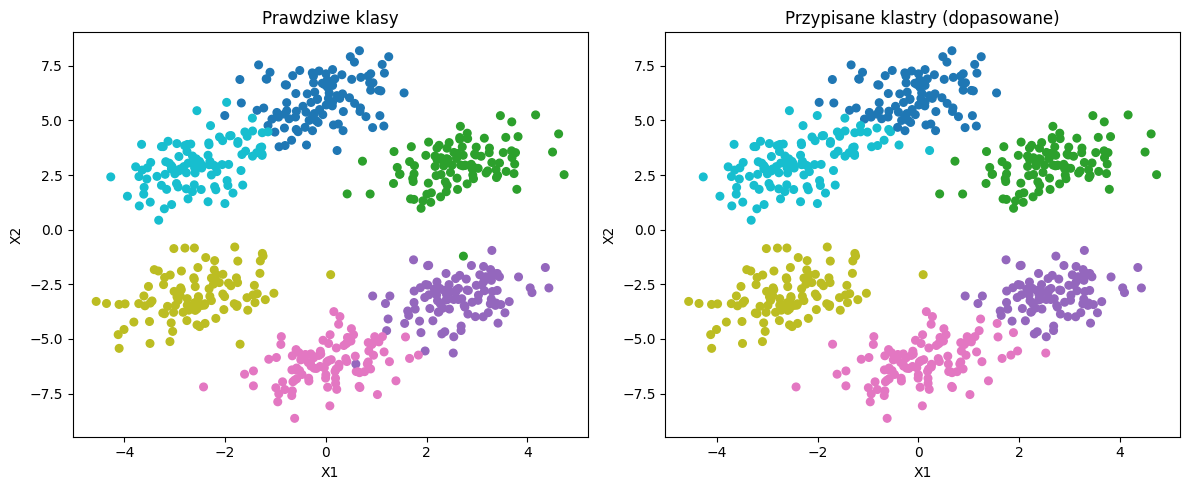

Dopasowana accuracy: 0.965
Liczba klastrów: 15
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 340 zawiera dane tylko z jednej klasy (1) i występuje 62 razy.
Klaster 60 zawiera dane tylko z jednej klasy (0) i występuje 43 razy.
Klaster 243 zawiera dane z różnych klas: {2: 39, 1: 1}
Klaster 113 zawiera dane tylko z jednej klasy (2) i występuje 54 razy.
Klaster 254 zawiera dane tylko z jednej klasy (1) i występuje 37 razy.
Klaster 239 zawiera dane tylko z jednej klasy (4) i występuje 26 razy.
Klaster 69 zawiera dane z różnych klas: {0: 46, 5: 1}
Klaster 34 zawiera dane tylko z jednej klasy (4) i występuje 43 razy.
Klaster 160 zawiera dane z różnych klas: {3: 55, 2: 1, 4: 1}
Klaster 171 zawiera dane z różnych klas: {3: 26, 2: 6}
Klaster 225 zawiera dane tylko z jednej klasy (5) i występuje 15 razy.
Klaster 292 zawiera dane tylko z jednej klasy (5) i występuje 59 razy.
Klaster 393 zawiera dane tylko z jednej klasy (3) i występuje 19 razy.
Klaster 23

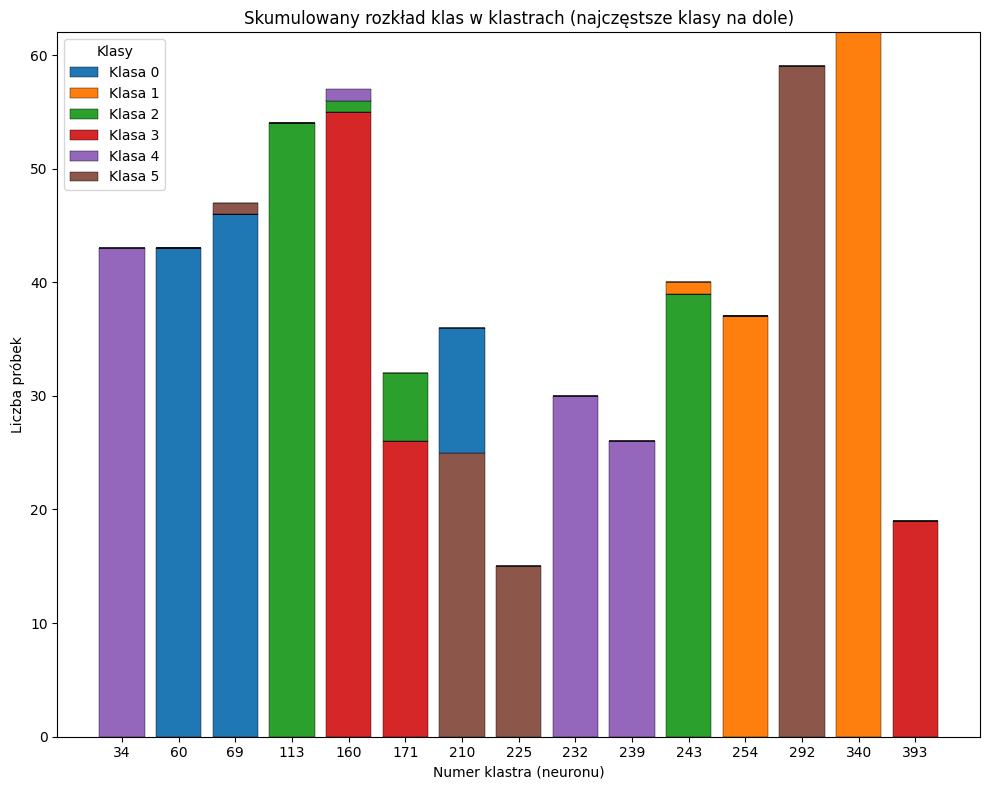

In [68]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=20, N=20, input_dim=2, neighborhood_function='second_derivative_gaussian', sigma=0.5)

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

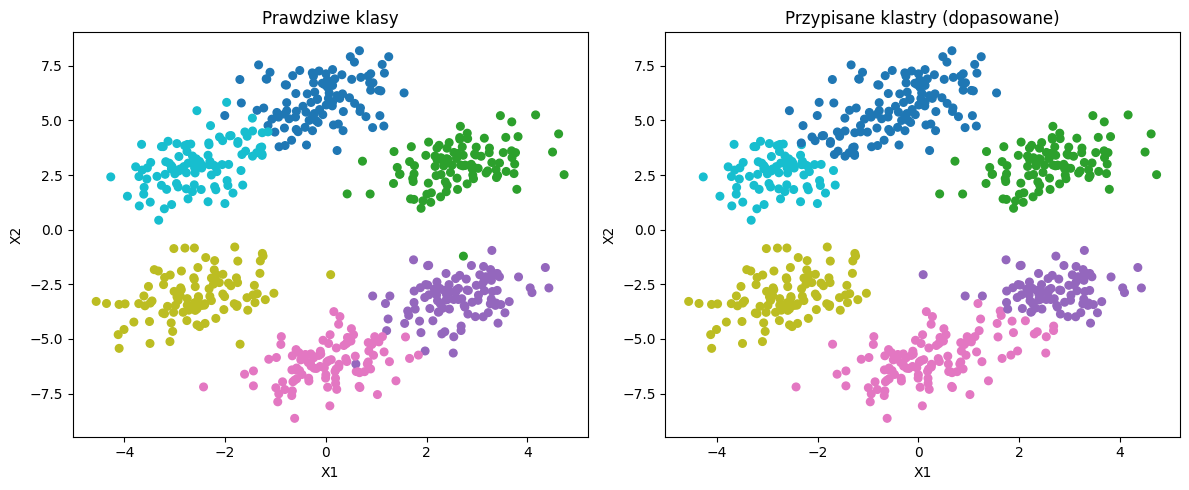

Dopasowana accuracy: 0.9266666666666666
Liczba klastrów: 8
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 5 zawiera dane tylko z jednej klasy (1) i występuje 99 razy.
Klaster 29 zawiera dane tylko z jednej klasy (0) i występuje 65 razy.
Klaster 71 zawiera dane z różnych klas: {2: 83, 4: 1, 1: 1}
Klaster 11 zawiera dane tylko z jednej klasy (4) i występuje 98 razy.
Klaster 81 zawiera dane z różnych klas: {0: 35, 5: 24}
Klaster 97 zawiera dane z różnych klas: {3: 74, 2: 1, 4: 1}
Klaster 10 zawiera dane z różnych klas: {3: 26, 2: 16}
Klaster 39 zawiera dane tylko z jednej klasy (5) i występuje 76 razy.

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[0 5]
 [1 0]
 [1 1]
 [2 9]
 [3 9]
 [7 1]
 [8 1]
 [9 7]]


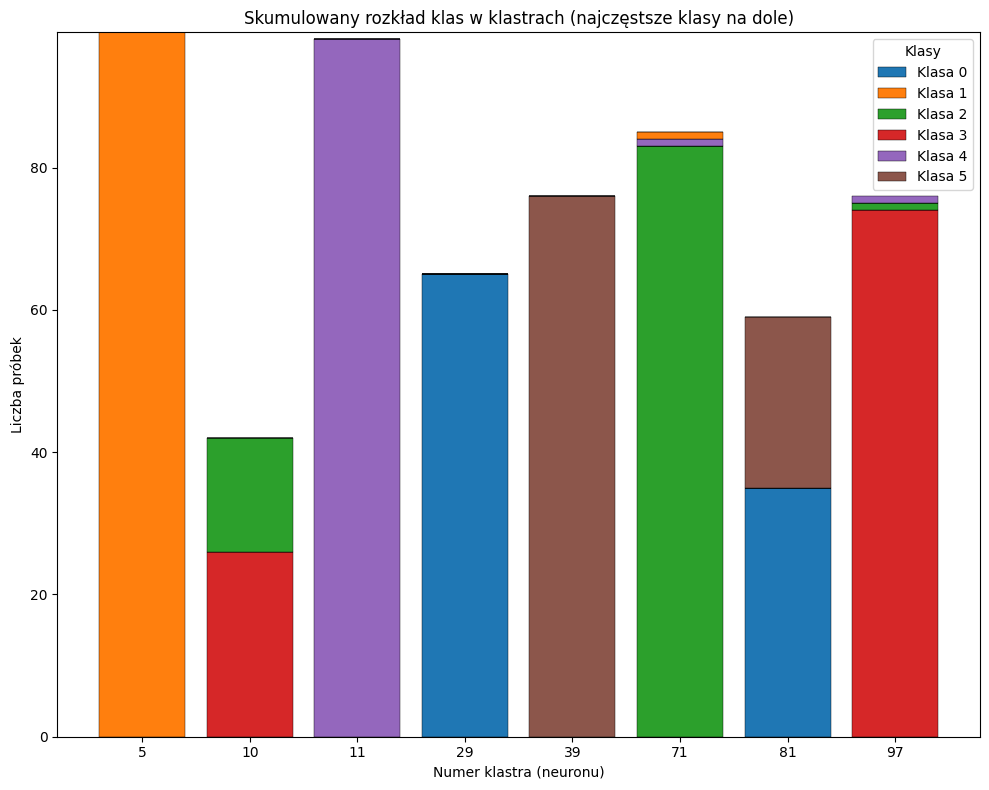

In [ ]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=2, neighborhood_function='second_derivative_gaussian')

network.train(X, epochs=5000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

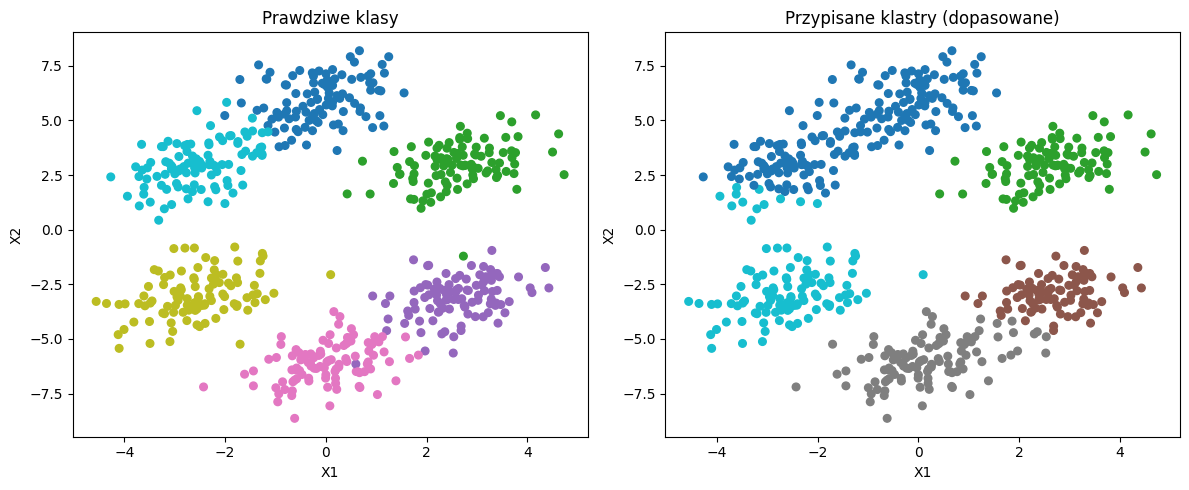

Dopasowana accuracy: 0.8116666666666666
Liczba klastrów: 5
Liczba klas: 6
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 40 zawiera dane tylko z jednej klasy (1) i występuje 99 razy.
Klaster 3 zawiera dane z różnych klas: {0: 100, 5: 88}
Klaster 49 zawiera dane z różnych klas: {2: 89, 1: 1}
Klaster 4 zawiera dane z różnych klas: {4: 99, 5: 12}
Klaster 35 zawiera dane z różnych klas: {3: 100, 2: 11, 4: 1}

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[0 3]
 [0 4]
 [7 0]
 [8 0]
 [9 4]]


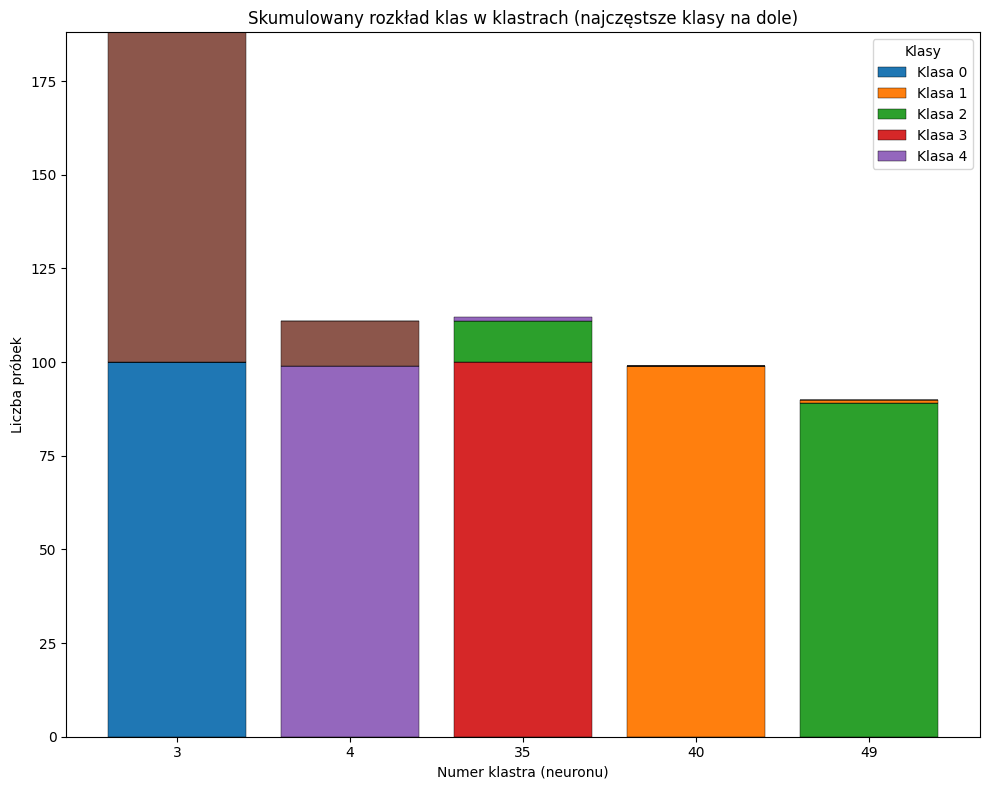

In [ ]:
df = pd.read_csv("./mio2/hexagon.csv")
X = df.iloc[:, :2].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=5, input_dim=2, neighborhood_function='second_derivative_gaussian')

network.train(X, epochs=1000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

| **Zbiór**       | **Rozmiar siatki** | **Szerokość sąsiedztwa** | **Liczba klastrów** | **Dokładność** |
|-----------------|------------------|-------------------|-------------------|-------------|
| Heksagon - Minus 2-gauss | 20×20   | 10               | 108              | 0.9883      |
| Heksagon - Minus 2-gauss | 20×20   | 1                | 22               | 0.96        |
| Heksagon - Minus 2-gauss | 20×20   | 0.5              | 15               | 0.965       |
| Heksagon - Minus 2-gauss | 10×10   | 1                | 8                | 0.9267      |
| Heksagon - Minus 2-gauss | 10×5    | 1                | 5                | 0.8117      |

### Zbiór cube

#### funkcja gaussowska

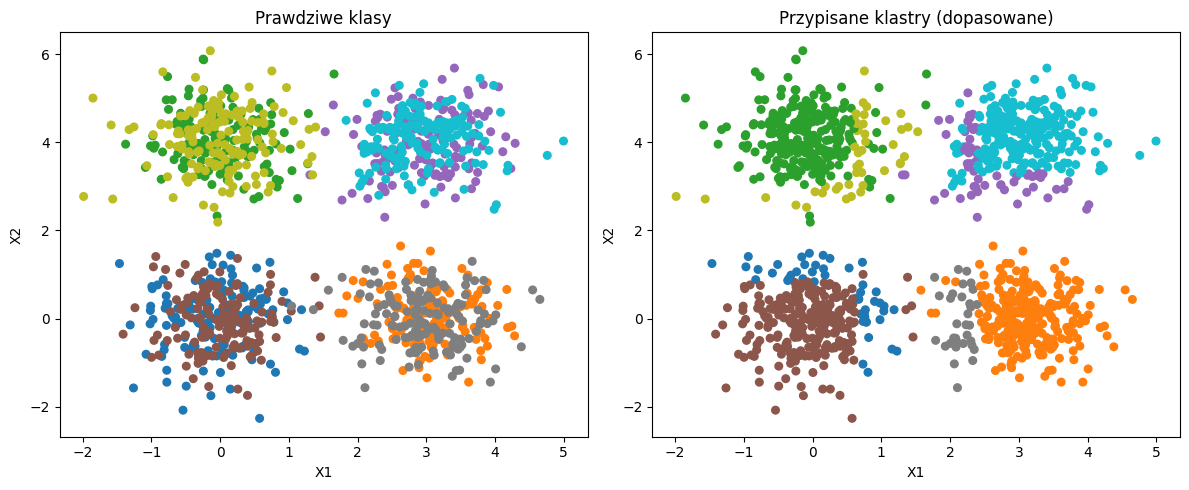

Dopasowana accuracy: 0.5441666666666667
Liczba klastrów: 54
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 99 zawiera dane z różnych klas: {0: 122, 4: 127}
Klaster 97 zawiera dane z różnych klas: {0: 3, 4: 2}
Klaster 78 zawiera dane tylko z jednej klasy (0) i występuje 1 razy.
Klaster 98 zawiera dane z różnych klas: {0: 8, 4: 6}
Klaster 79 zawiera dane z różnych klas: {0: 5, 4: 5}
Klaster 89 zawiera dane z różnych klas: {0: 5, 4: 5}
Klaster 69 zawiera dane tylko z jednej klasy (0) i występuje 3 razy.
Klaster 96 zawiera dane z różnych klas: {0: 3, 4: 1, 5: 1}
Klaster 90 zawiera dane z różnych klas: {1: 124, 5: 118}
Klaster 60 zawiera dane tylko z jednej klasy (1) i występuje 2 razy.
Klaster 91 zawiera dane z różnych klas: {1: 4, 5: 9}
Klaster 70 zawiera dane z różnych klas: {1: 5, 5: 1}
Klaster 82 zawiera dane tylko z jednej klasy (1) i występuje 1 razy.
Klaster 80 zawiera dane z różnych klas: {1: 5, 5: 5}
Klaster 92 zawiera dane z różnych klas:

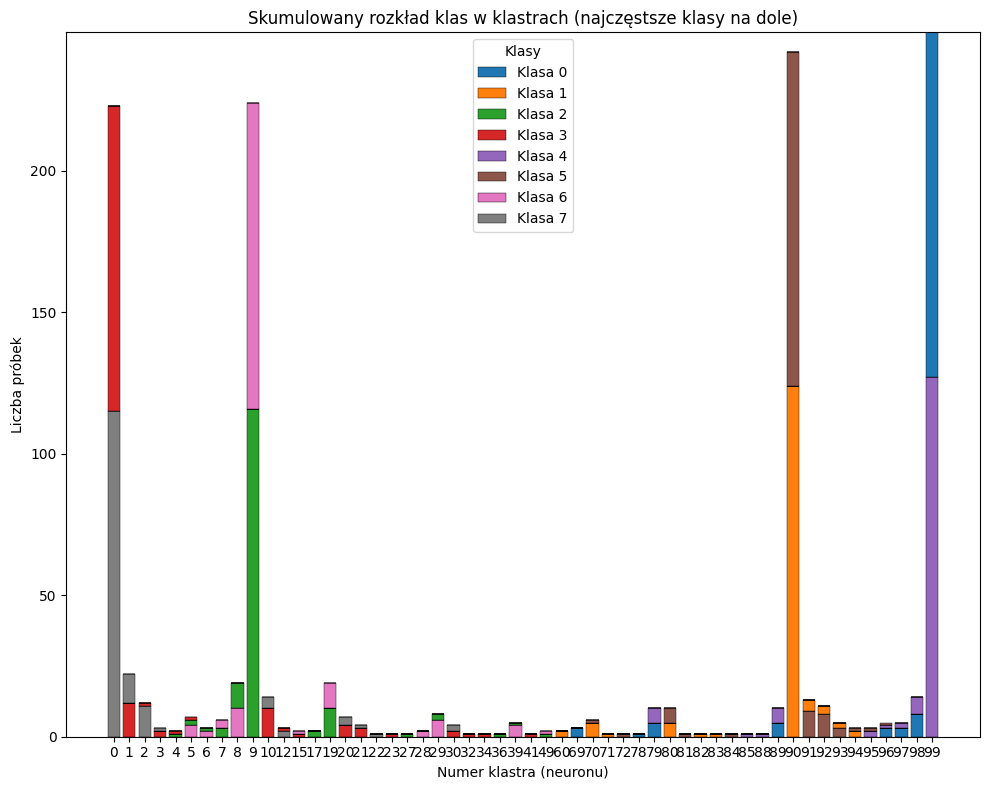

In [70]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=3, sigma=5)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

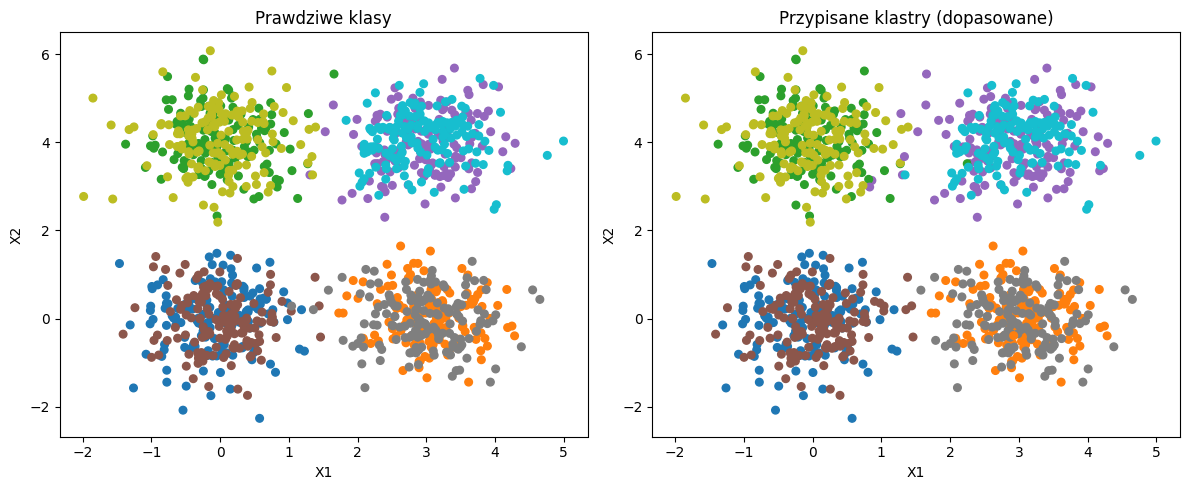

Dopasowana accuracy: 0.9566666666666667
Liczba klastrów: 91
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 88 zawiera dane tylko z jednej klasy (0) i występuje 13 razy.
Klaster 98 zawiera dane tylko z jednej klasy (0) i występuje 23 razy.
Klaster 97 zawiera dane z różnych klas: {0: 22, 4: 1}
Klaster 87 zawiera dane z różnych klas: {0: 17, 4: 1}
Klaster 99 zawiera dane tylko z jednej klasy (0) i występuje 43 razy.
Klaster 0 zawiera dane z różnych klas: {0: 2, 4: 33}
Klaster 89 zawiera dane tylko z jednej klasy (0) i występuje 25 razy.
Klaster 22 zawiera dane z różnych klas: {0: 2, 4: 7, 5: 2}
Klaster 20 zawiera dane z różnych klas: {0: 2, 4: 20}
Klaster 31 zawiera dane z różnych klas: {0: 1, 4: 6}
Klaster 8 zawiera dane tylko z jednej klasy (1) i występuje 20 razy.
Klaster 17 zawiera dane z różnych klas: {1: 12, 5: 1}
Klaster 19 zawiera dane tylko z jednej klasy (1) i występuje 19 razy.
Klaster 29 zawiera dane tylko z jednej klasy (1) i występuj

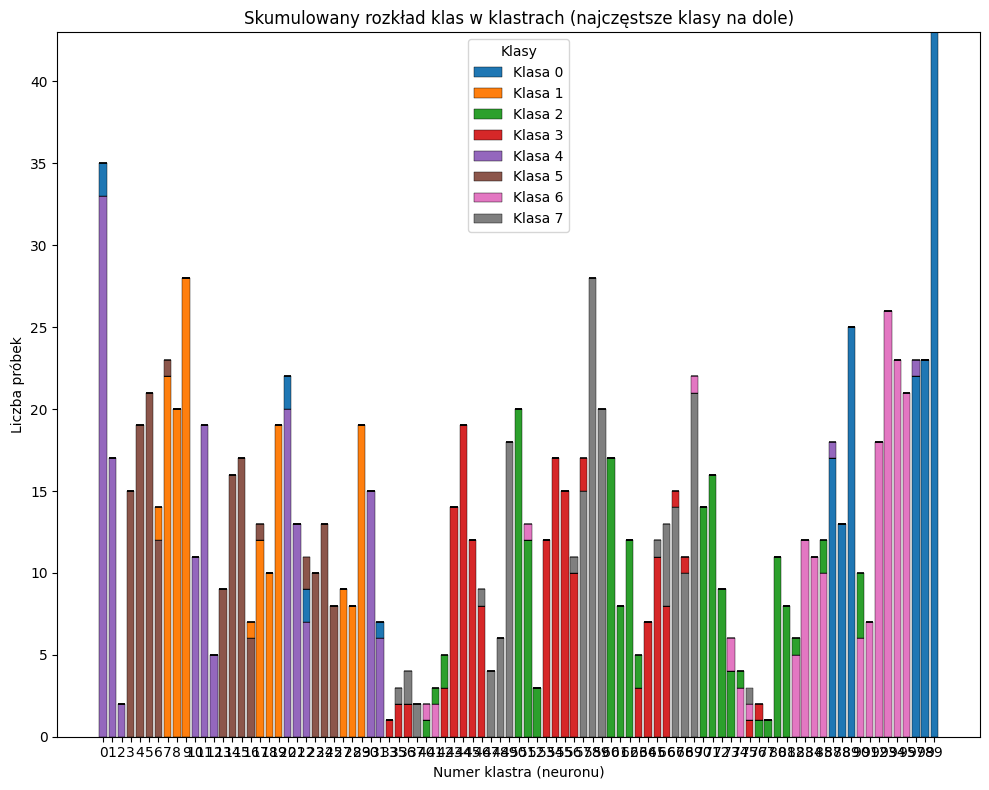

In [54]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=3)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

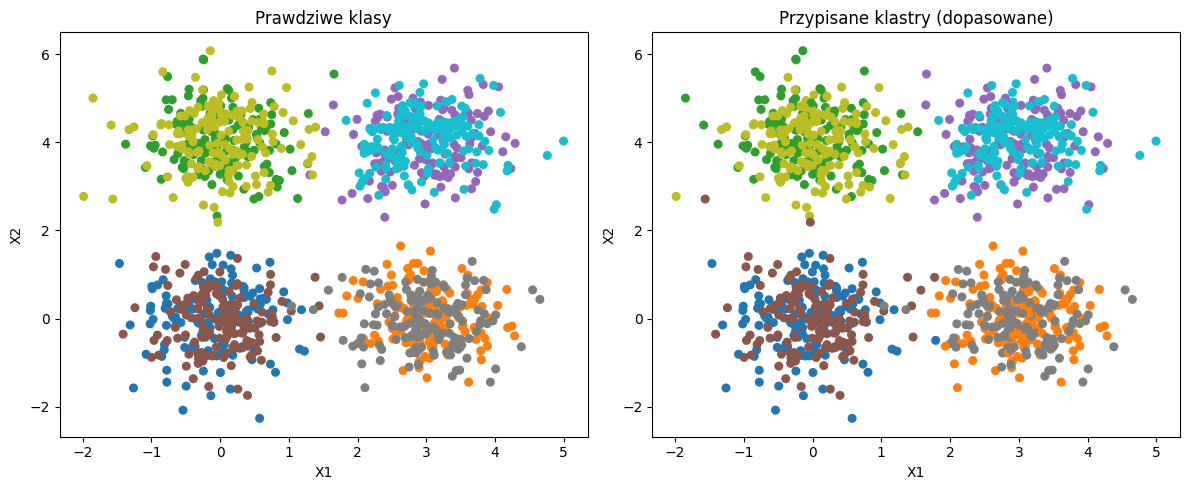

Dopasowana accuracy: 0.9433333333333334
Liczba klastrów: 68
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 62 zawiera dane tylko z jednej klasy (0) i występuje 3 razy.
Klaster 86 zawiera dane tylko z jednej klasy (0) i występuje 13 razy.
Klaster 16 zawiera dane tylko z jednej klasy (0) i występuje 4 razy.
Klaster 15 zawiera dane tylko z jednej klasy (0) i występuje 1 razy.
Klaster 97 zawiera dane tylko z jednej klasy (0) i występuje 10 razy.
Klaster 53 zawiera dane tylko z jednej klasy (0) i występuje 1 razy.
Klaster 47 zawiera dane tylko z jednej klasy (0) i występuje 15 razy.
Klaster 21 zawiera dane z różnych klas: {0: 11, 4: 3}
Klaster 92 zawiera dane tylko z jednej klasy (0) i występuje 2 razy.
Klaster 93 zawiera dane tylko z jednej klasy (0) i występuje 12 razy.
Klaster 98 zawiera dane tylko z jednej klasy (0) i występuje 3 razy.
Klaster 41 zawiera dane z różnych klas: {0: 9, 4: 1}
Klaster 37 zawiera dane tylko z jednej klasy (0) i występu

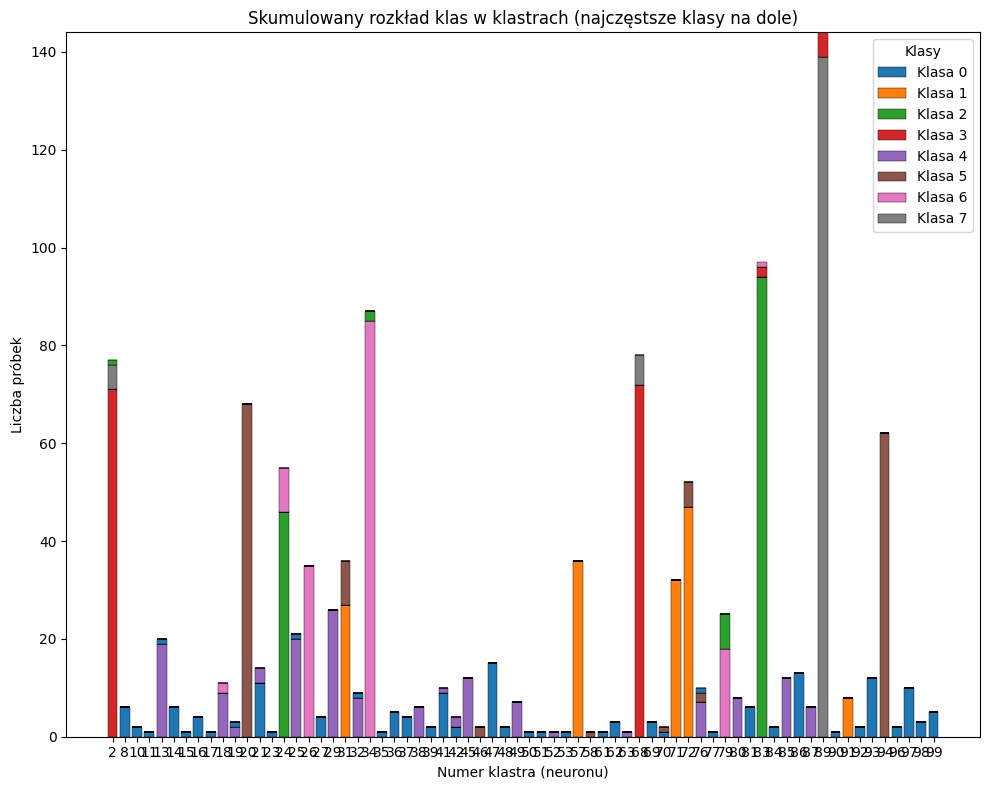

In [71]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=3, sigma=0.1)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

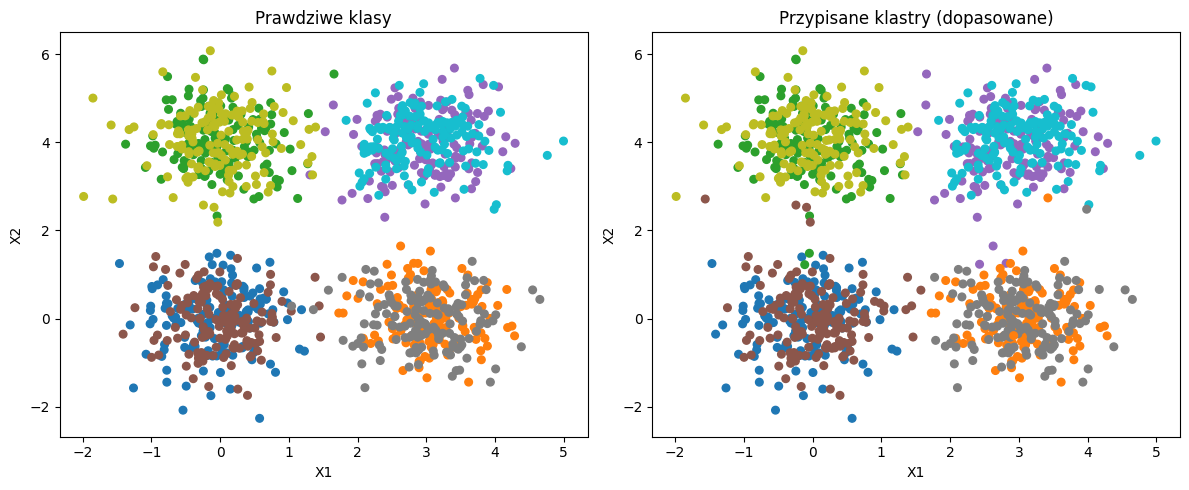

Dopasowana accuracy: 0.9516666666666667
Liczba klastrów: 48
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 31 zawiera dane z różnych klas: {0: 23, 4: 2}
Klaster 40 zawiera dane tylko z jednej klasy (0) i występuje 50 razy.
Klaster 30 zawiera dane tylko z jednej klasy (0) i występuje 39 razy.
Klaster 42 zawiera dane z różnych klas: {0: 3, 4: 20}
Klaster 20 zawiera dane tylko z jednej klasy (0) i występuje 7 razy.
Klaster 41 zawiera dane z różnych klas: {0: 21, 4: 1}
Klaster 32 zawiera dane z różnych klas: {0: 3, 4: 14}
Klaster 33 zawiera dane z różnych klas: {0: 1, 4: 30}
Klaster 21 zawiera dane z różnych klas: {0: 2, 2: 3}
Klaster 34 zawiera dane z różnych klas: {0: 1, 4: 10, 5: 3}
Klaster 49 zawiera dane tylko z jednej klasy (1) i występuje 54 razy.
Klaster 38 zawiera dane tylko z jednej klasy (1) i występuje 22 razy.
Klaster 39 zawiera dane tylko z jednej klasy (1) i występuje 31 razy.
Klaster 37 zawiera dane z różnych klas: {1: 3, 5: 9}
Klas

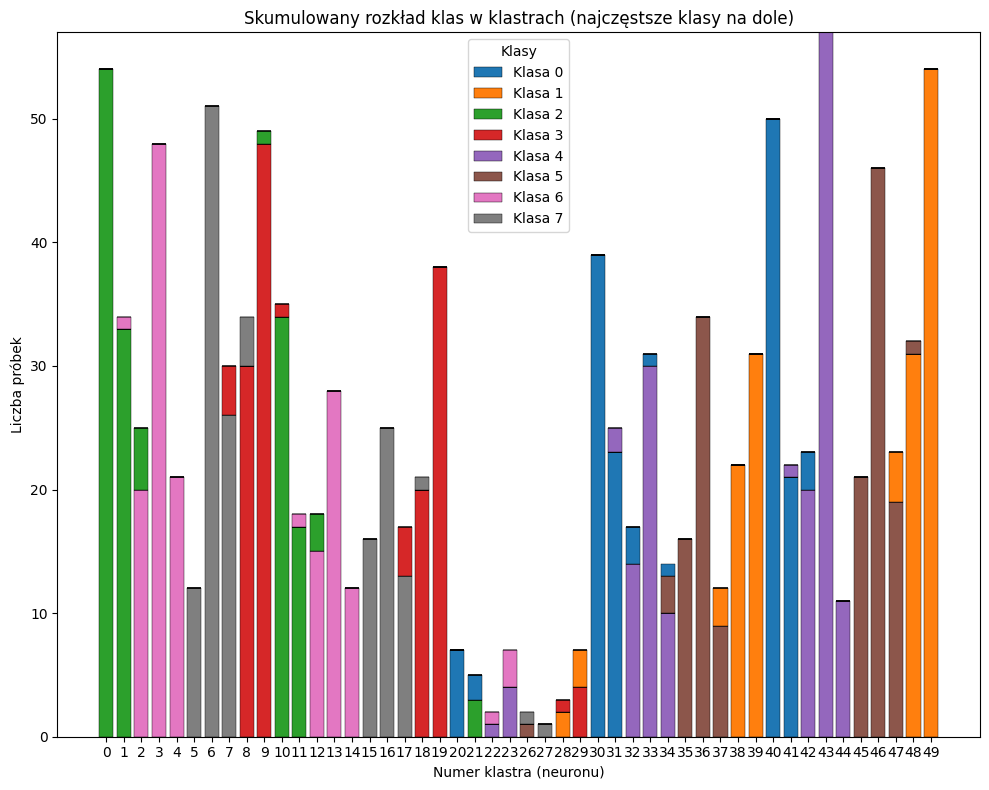

In [53]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=5, N=10, input_dim=3)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

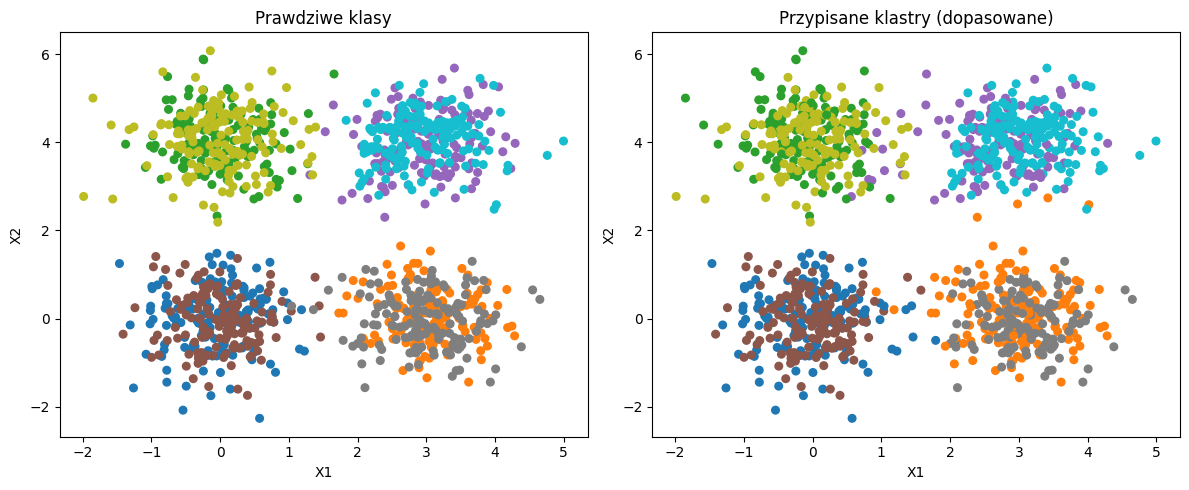

Dopasowana accuracy: 0.9075
Liczba klastrów: 25
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 15 zawiera dane z różnych klas: {0: 97, 4: 1}
Klaster 11 zawiera dane z różnych klas: {0: 2, 1: 8}
Klaster 16 zawiera dane z różnych klas: {0: 31, 4: 3, 5: 1}
Klaster 20 zawiera dane z różnych klas: {0: 5, 4: 87}
Klaster 10 zawiera dane z różnych klas: {0: 12, 1: 1, 4: 2, 5: 2}
Klaster 21 zawiera dane z różnych klas: {0: 3, 4: 57, 5: 1}
Klaster 6 zawiera dane tylko z jednej klasy (1) i występuje 91 razy.
Klaster 5 zawiera dane z różnych klas: {1: 19, 5: 11}
Klaster 1 zawiera dane z różnych klas: {1: 19, 5: 8}
Klaster 7 zawiera dane z różnych klas: {1: 9, 3: 2}
Klaster 2 zawiera dane z różnych klas: {1: 2, 3: 1, 7: 1}
Klaster 0 zawiera dane z różnych klas: {1: 1, 5: 127}
Klaster 19 zawiera dane tylko z jednej klasy (2) i występuje 102 razy.
Klaster 13 zawiera dane z różnych klas: {2: 5, 3: 8}
Klaster 24 zawiera dane z różnych klas: {2: 21, 6: 15}
Klast

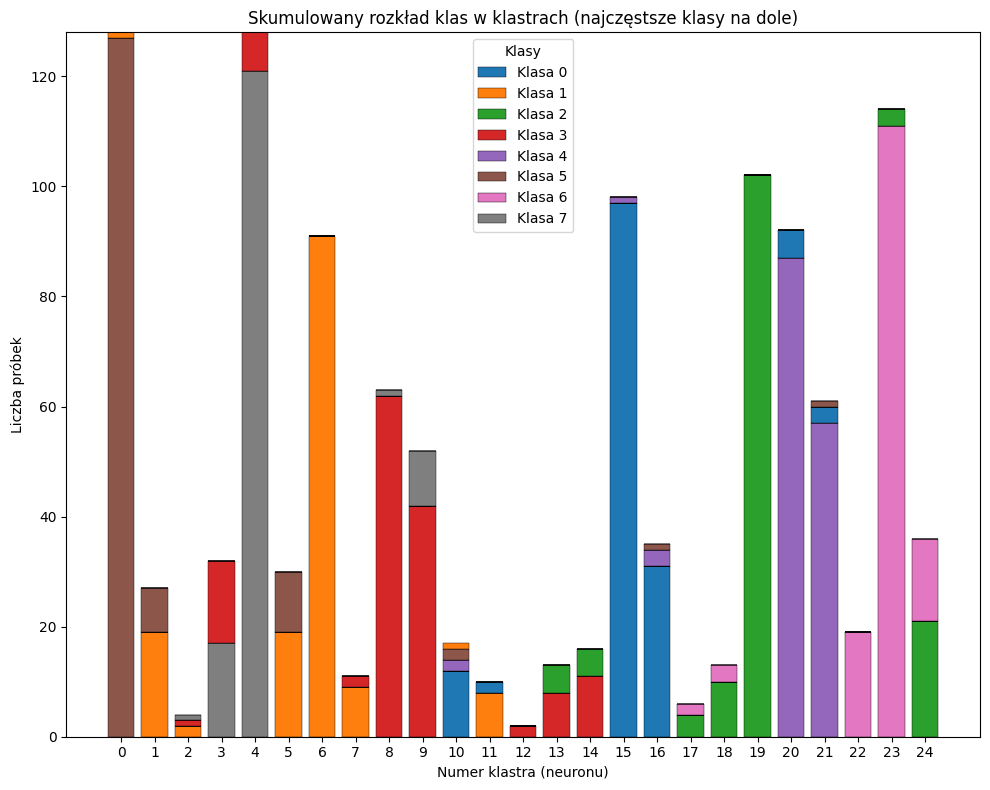

In [55]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=5, N=5, input_dim=3)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

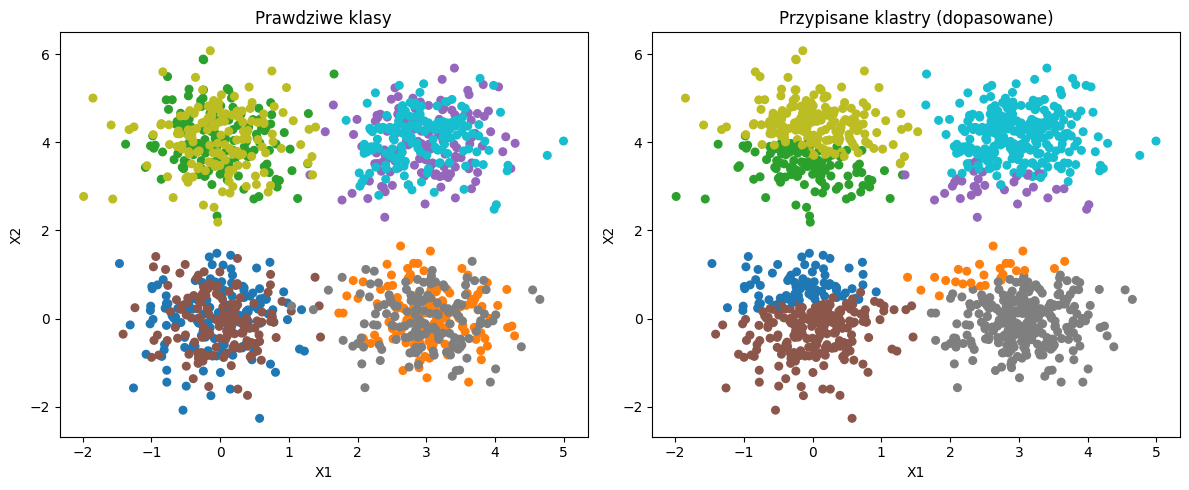

Dopasowana accuracy: 0.5425
Liczba klastrów: 8
Liczba klas: 8
Liczba klastrów pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 3 zawiera dane z różnych klas: {0: 101, 4: 111, 5: 2}
Klaster 2 zawiera dane z różnych klas: {0: 49, 4: 38}
Klaster 7 zawiera dane z różnych klas: {1: 133, 5: 140}
Klaster 6 zawiera dane z różnych klas: {1: 17, 4: 1, 5: 8}
Klaster 1 zawiera dane z różnych klas: {2: 70, 3: 1, 6: 46}
Klaster 0 zawiera dane z różnych klas: {2: 79, 3: 1, 6: 103}
Klaster 4 zawiera dane z różnych klas: {2: 1, 3: 126, 7: 139}
Klaster 5 zawiera dane z różnych klas: {3: 22, 6: 1, 7: 11}

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 0]
 [1 1]
 [1 2]
 [1 3]]


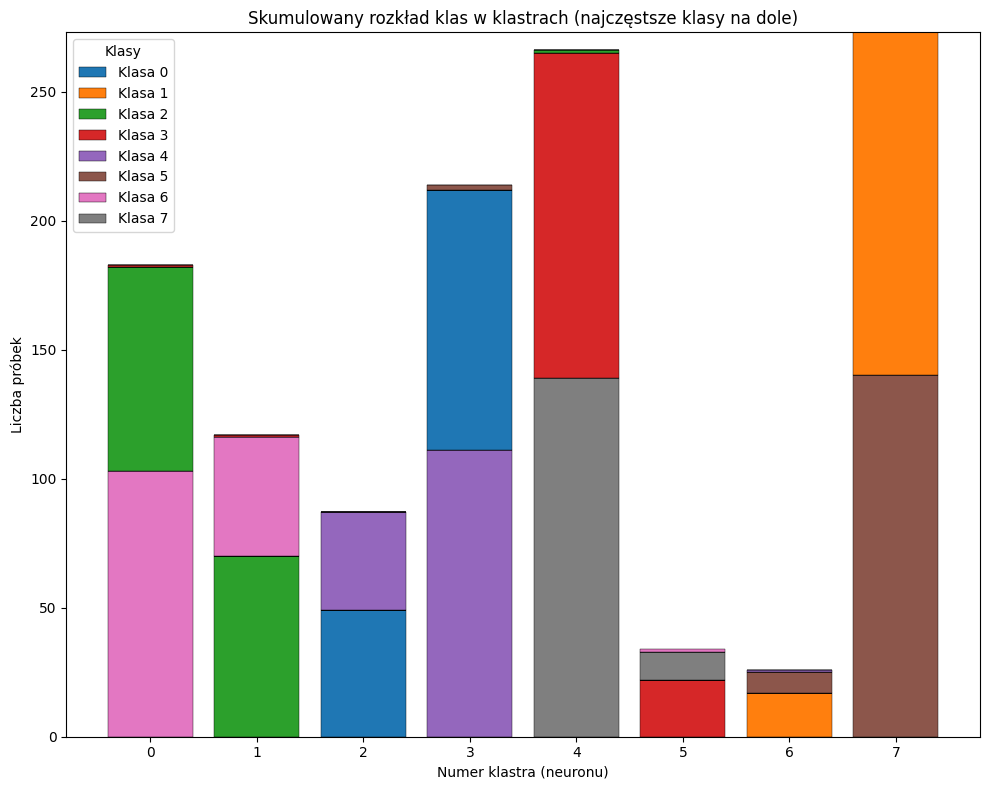

In [56]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=2, N=4, input_dim=3)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

| **Zbiór**                | **Rozmiar siatki** | **Szerokość sąsiedztwa** | **Liczba klastrów** | **Dokładność** |
|--------------------------|--------------------|--------------------------|---------------------|----------------|
| Cube - Gauss             | 10×10              | 5                        | 54                  | 0.5442         |
| Cube - Gauss             | 10×10              | 1                        | 91                  | 0.9567         |
| Cube - Gauss             | 10×10              | 0.1                      | 68                  | 0.9433         |
| Cube - Gauss             | 5×10               | 1                        | 48                  | 0.9517         |
| Cube - Gauss             | 5x5                | 1                        | 25                  | 0.9075         |
| Cube - Gauss             | 2x4                | 1                        | 8                   | 0.5425         |

#### minus druga pochodna funkcji gaussowskiej

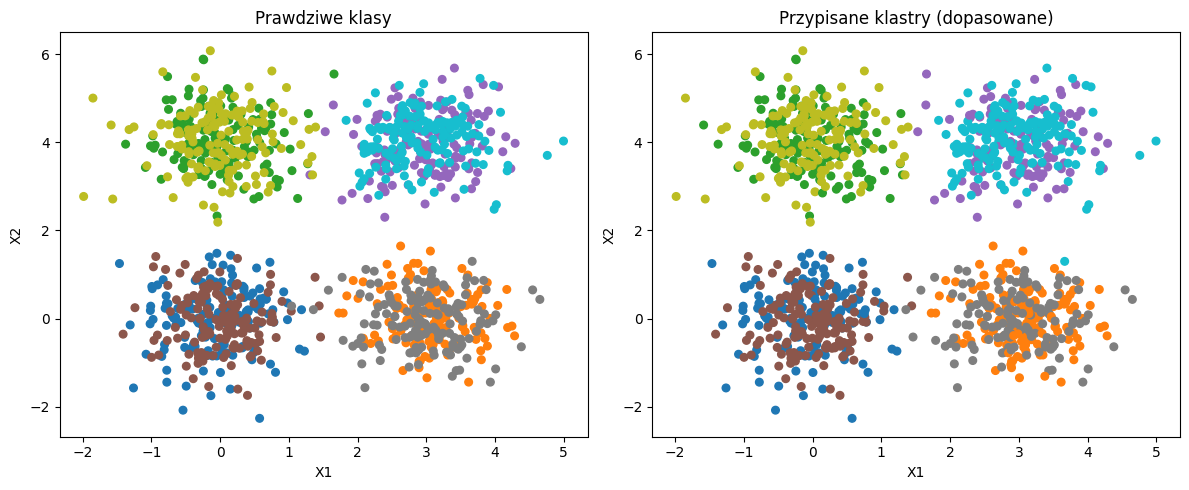

Dopasowana accuracy: 0.9375
Liczba klastrów: 32
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 300 zawiera dane z różnych klas: {0: 50, 4: 5}
Klaster 368 zawiera dane tylko z jednej klasy (0) i występuje 53 razy.
Klaster 100 zawiera dane tylko z jednej klasy (0) i występuje 27 razy.
Klaster 2 zawiera dane z różnych klas: {0: 15, 4: 23}
Klaster 278 zawiera dane tylko z jednej klasy (0) i występuje 3 razy.
Klaster 31 zawiera dane z różnych klas: {0: 1, 4: 44}
Klaster 215 zawiera dane z różnych klas: {0: 1, 4: 50, 5: 1}
Klaster 367 zawiera dane tylko z jednej klasy (1) i występuje 37 razy.
Klaster 304 zawiera dane tylko z jednej klasy (1) i występuje 38 razy.
Klaster 358 zawiera dane z różnych klas: {1: 26, 5: 5}
Klaster 331 zawiera dane tylko z jednej klasy (1) i występuje 30 razy.
Klaster 272 zawiera dane z różnych klas: {1: 19, 5: 11}
Klaster 117 zawiera dane z różnych klas: {2: 64, 6: 2}
Klaster 393 zawiera dane tylko z jednej klasy (2) i wyst

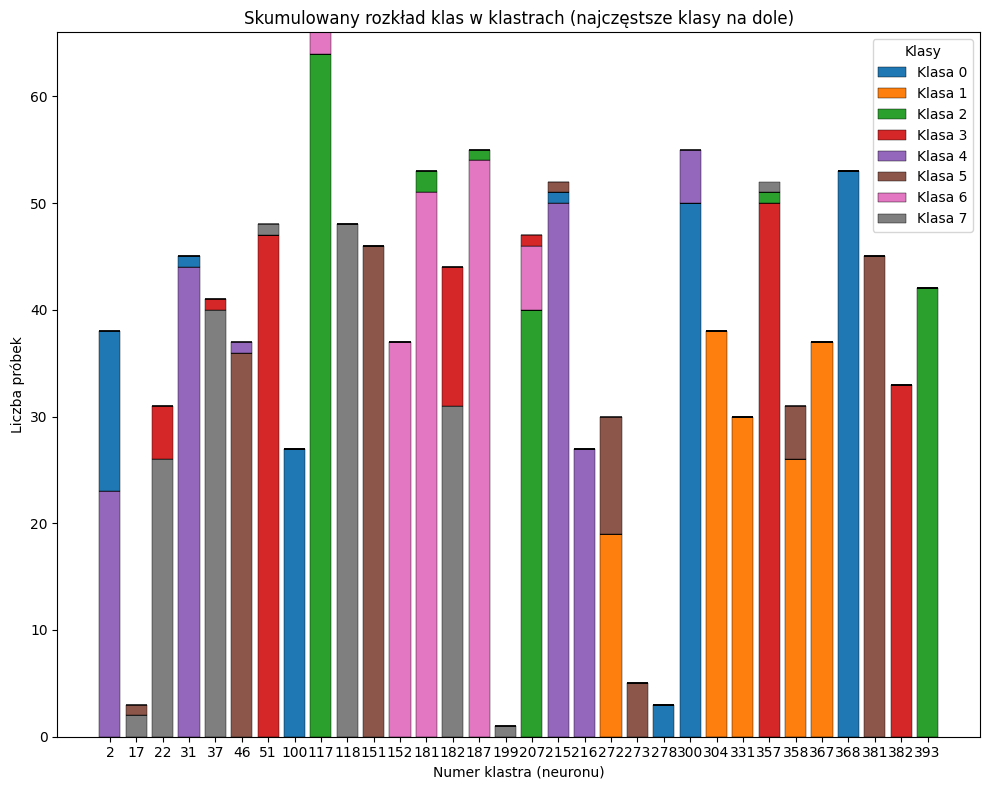

In [62]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=20, N=20, input_dim=3, neighborhood_function='second_derivative_gaussian')

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

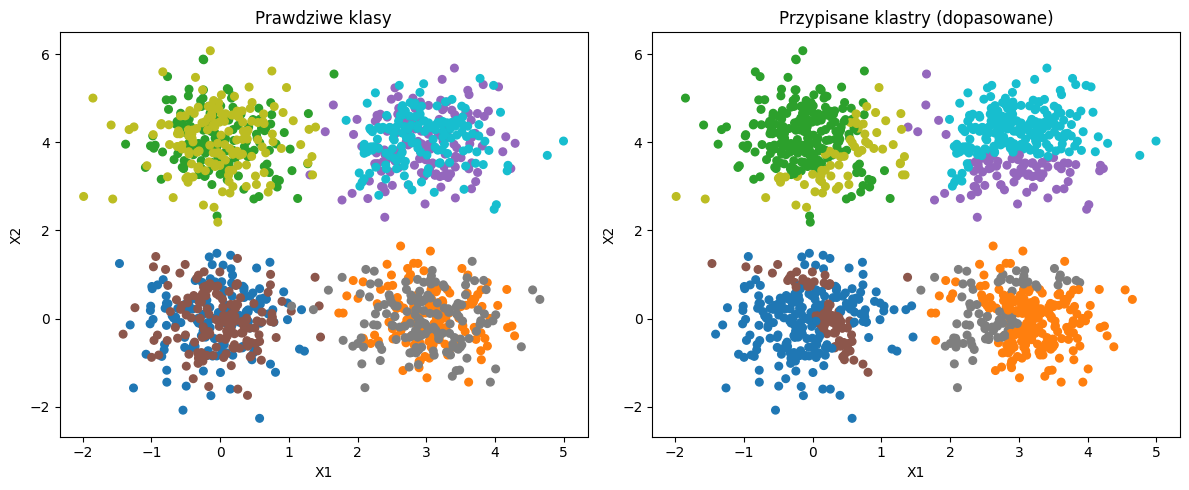

Dopasowana accuracy: 0.5883333333333334
Liczba klastrów: 63
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 8 zawiera dane z różnych klas: {0: 28, 4: 21}
Klaster 9 zawiera dane z różnych klas: {0: 58, 4: 56}
Klaster 28 zawiera dane z różnych klas: {0: 5, 4: 2}
Klaster 27 zawiera dane z różnych klas: {0: 1, 4: 1}
Klaster 18 zawiera dane z różnych klas: {0: 7, 4: 2}
Klaster 19 zawiera dane z różnych klas: {0: 21, 4: 37}
Klaster 29 zawiera dane z różnych klas: {0: 9, 4: 7}
Klaster 6 zawiera dane z różnych klas: {0: 6, 4: 2}
Klaster 39 zawiera dane z różnych klas: {0: 3, 4: 2, 5: 1}
Klaster 7 zawiera dane z różnych klas: {0: 9, 4: 17}
Klaster 49 zawiera dane z różnych klas: {0: 2, 4: 2, 5: 1}
Klaster 17 zawiera dane tylko z jednej klasy (0) i występuje 1 razy.
Klaster 99 zawiera dane z różnych klas: {1: 66, 5: 52}
Klaster 89 zawiera dane z różnych klas: {1: 12, 5: 24}
Klaster 98 zawiera dane z różnych klas: {1: 37, 5: 28}
Klaster 95 zawiera dane tyl

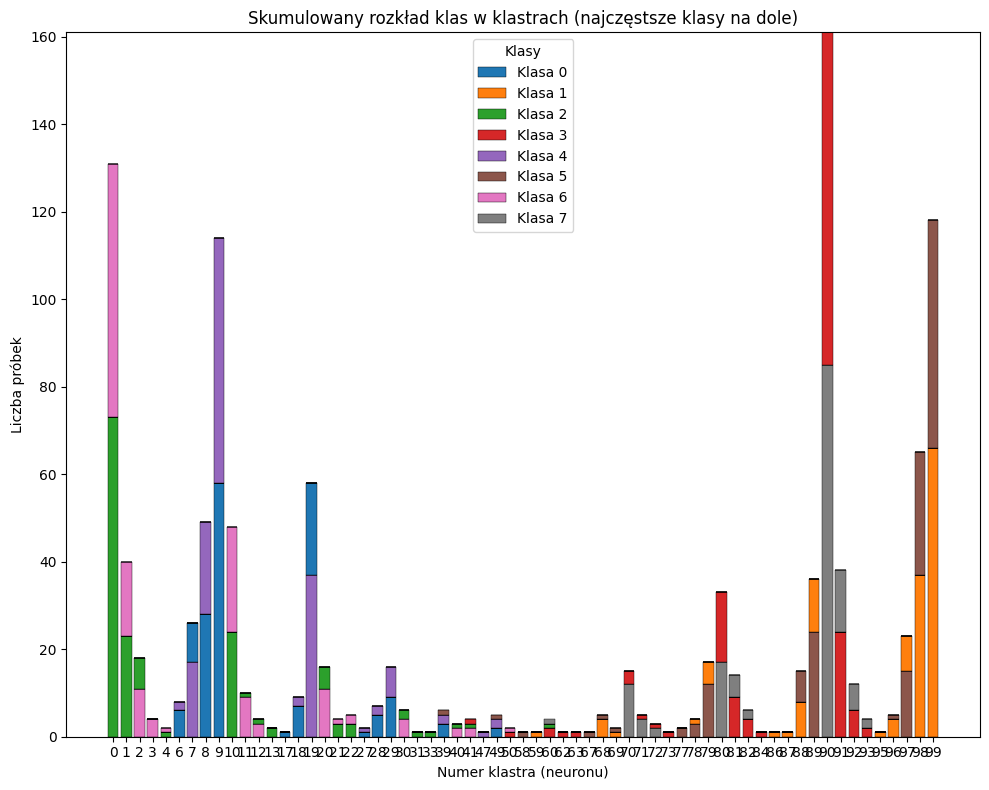

In [72]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=3, neighborhood_function='second_derivative_gaussian', sigma=10)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

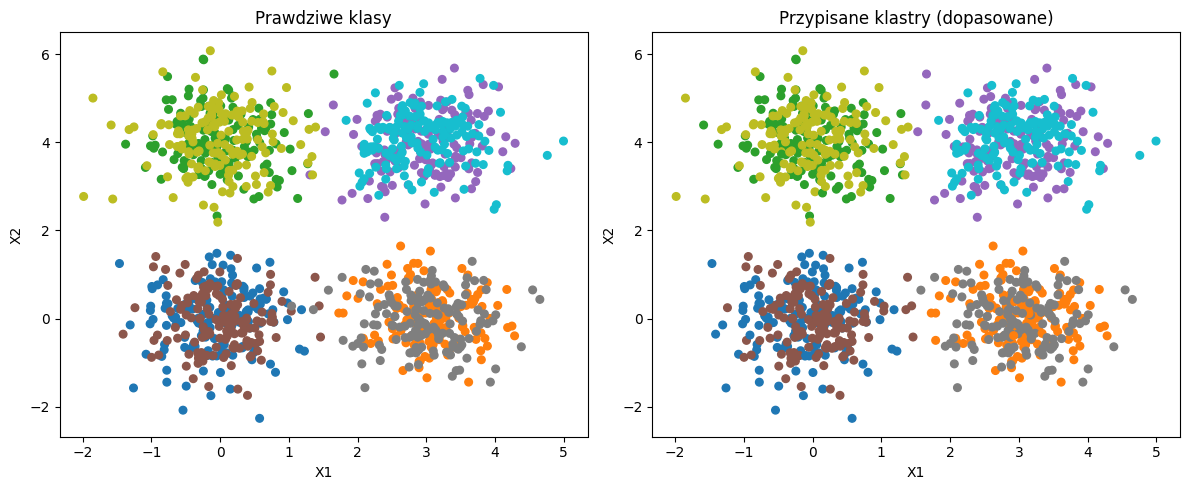

Dopasowana accuracy: 0.96
Liczba klastrów: 9
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 91 zawiera dane z różnych klas: {0: 98, 4: 3}
Klaster 86 zawiera dane z różnych klas: {0: 47, 4: 3}
Klaster 1 zawiera dane z różnych klas: {0: 5, 4: 144, 5: 2}
Klaster 39 zawiera dane z różnych klas: {1: 149, 5: 7}
Klaster 11 zawiera dane z różnych klas: {1: 1, 5: 141}
Klaster 87 zawiera dane z różnych klas: {2: 146, 3: 1, 6: 7}
Klaster 49 zawiera dane z różnych klas: {2: 1, 3: 143, 7: 9}
Klaster 34 zawiera dane z różnych klas: {2: 3, 6: 143}
Klaster 50 zawiera dane z różnych klas: {3: 6, 7: 141}

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[0 1]
 [1 1]
 [3 4]
 [3 9]
 [4 9]
 [5 0]
 [8 6]
 [8 7]
 [9 1]]


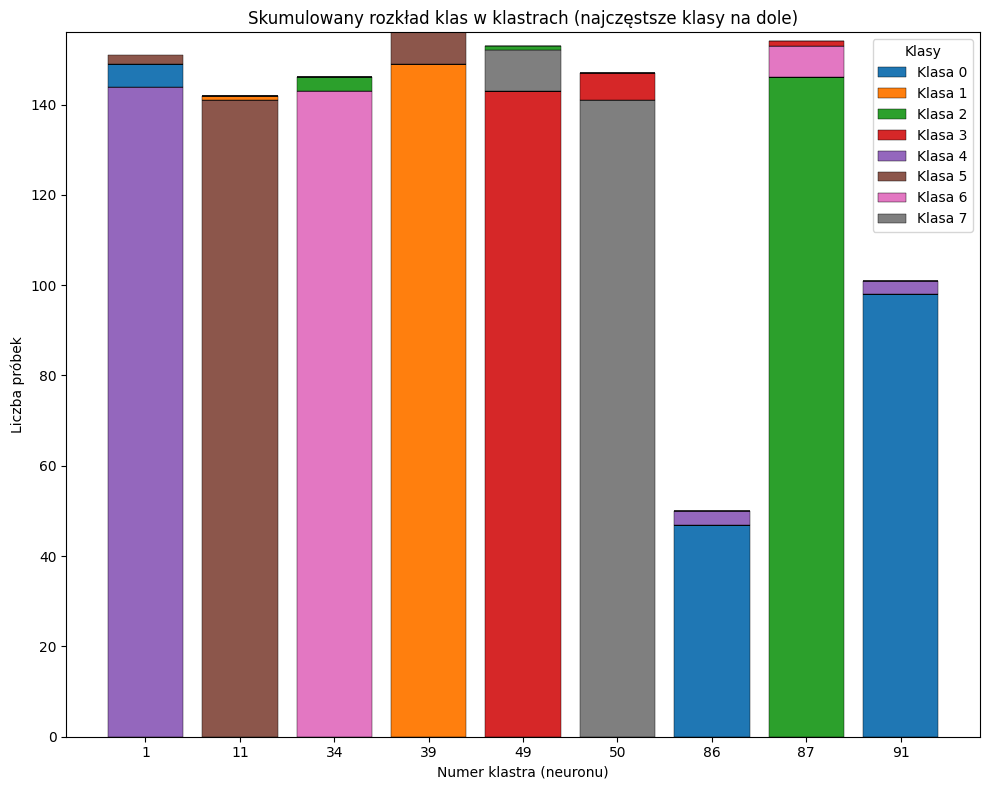

In [57]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=3, neighborhood_function='second_derivative_gaussian')

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

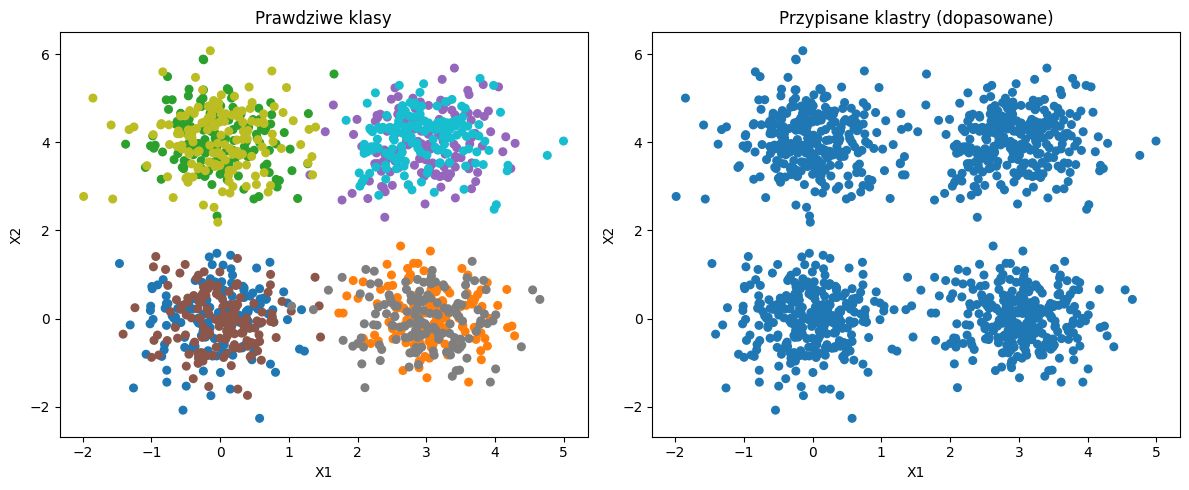

Dopasowana accuracy: 0.125
Liczba klastrów: 1
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 87 zawiera dane z różnych klas: {0: 150, 1: 150, 2: 150, 3: 150, 4: 150, 5: 150, 6: 150, 7: 150}

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[8 7]]


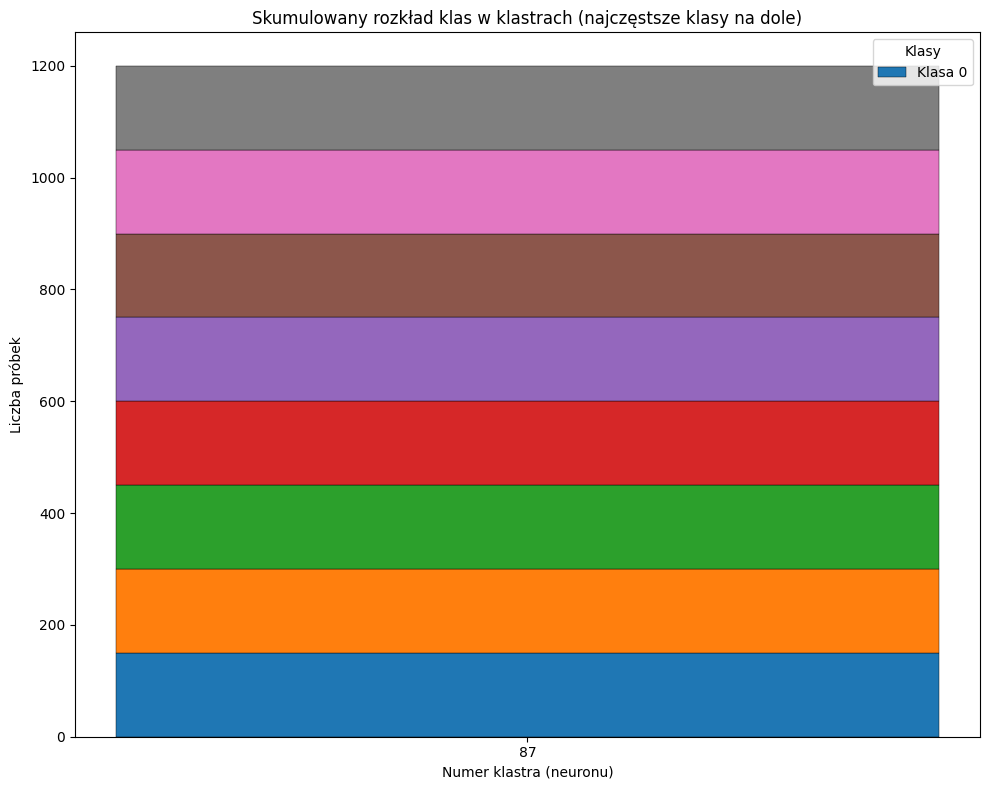

In [75]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=10, N=10, input_dim=3, neighborhood_function='second_derivative_gaussian', sigma=0.3)

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

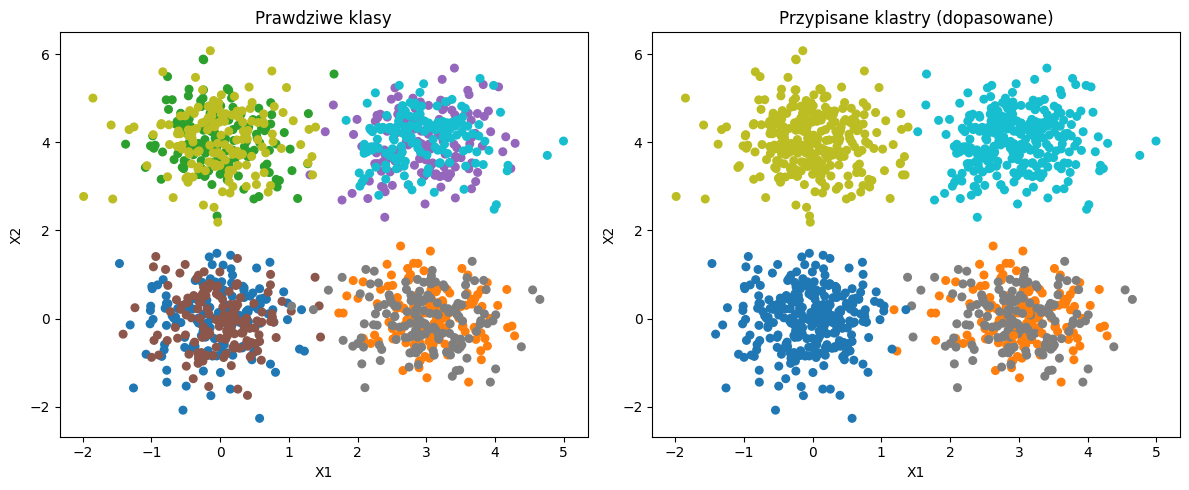

Dopasowana accuracy: 0.6166666666666667
Liczba klastrów: 5
Liczba klas: 8
Liczba klastrów nie pokrywa się z liczbą klas.

Analiza klastrów:
Klaster 6 zawiera dane z różnych klas: {0: 148, 4: 147, 5: 2}
Klaster 5 zawiera dane z różnych klas: {0: 2, 1: 150, 5: 6}
Klaster 22 zawiera dane z różnych klas: {2: 149, 3: 1, 6: 150}
Klaster 47 zawiera dane z różnych klas: {2: 1, 3: 149, 7: 150}
Klaster 32 zawiera dane z różnych klas: {4: 3, 5: 142}

Pozycje neuronów (indeksy klastrów w przestrzeni danych):
[[0 5]
 [0 6]
 [2 2]
 [3 2]
 [4 7]]


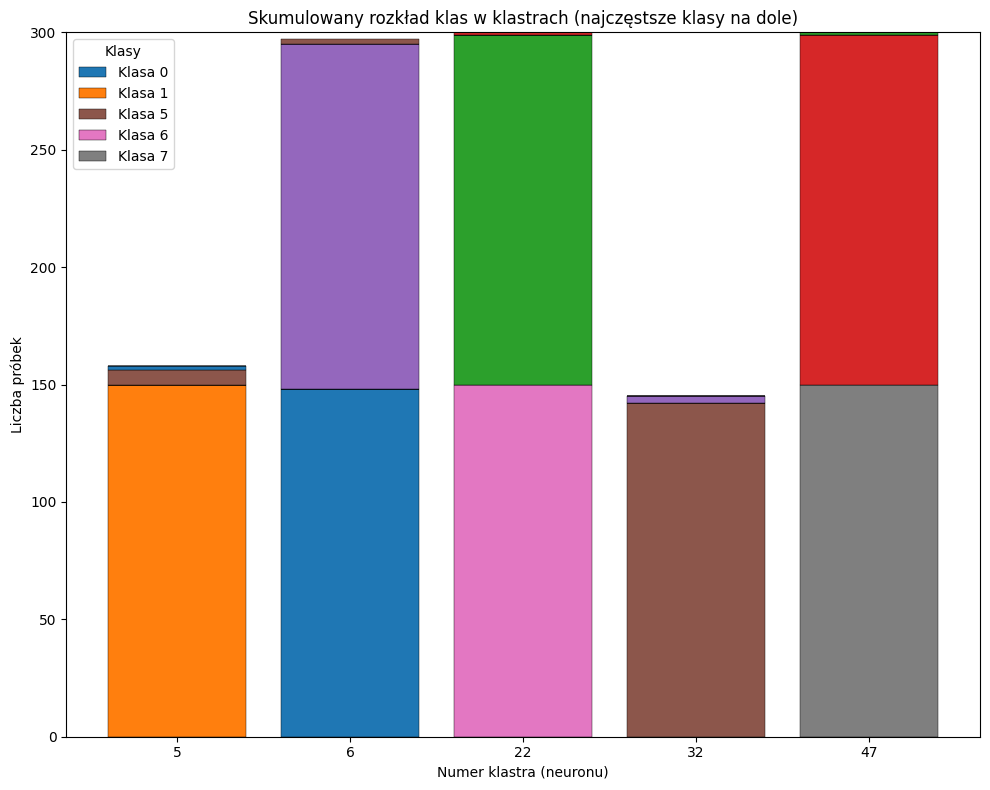

In [58]:
df = pd.read_csv("./mio2/cube.csv")
X = df.iloc[:, :3].values
y = df.iloc[:, -1].values

network = KohonenNetwork(M=5, N=10, input_dim=3, neighborhood_function='second_derivative_gaussian')

network.train(X, epochs=100000)
preds = network.get_cluster_assignments(X)

accuracy_plot(X,y,preds)

analyze_clusters(network, X, y)

plot_cluster_class_distribution(network, X, y)

| **Zbiór**                | **Rozmiar siatki** | **Szerokość sąsiedztwa** | **Liczba klastrów** | **Dokładność** |
|--------------------------|--------------------|--------------------------|---------------------|----------------|
| Cube - Minus 2-gauss     | 20×20              | 1                        | 32                  | 0.9375         |
| Cube - Minus 2-gauss     | 10×10              | 10                       | 63                  | 0.5883         |
| Cube - Minus 2-gauss     | 10×10              | 1                        | 9                   | 0.96           |
| Cube - Minus 2-gauss     | 10×10              | 0.3                      | 1                   | 0.125          |
| Cube - Minus 2-gauss     | 5×10               | 1                        | 5                   | 0.6167         |

## Podsumowanie

| **Zbiór**                | **Rozmiar siatki** | **Szerokość sąsiedztwa** | **Liczba klastrów** | **Dokładność** |
|--------------------------|--------------------|--------------------------|---------------------|----------------|
| Heksagon - Gauss         | 10×10              | 1                        | 92                  | 0.9783         |
| Heksagon - Gauss         | 10×5               | 5                        | 24                  | 0.77           |
| Heksagon - Gauss         | 10×5               | 1                        | 49                  | 0.9833         |
| Heksagon - Gauss         | 10×5               | 0.1                      | 5                   | 0.9817         |
| Heksagon - Gauss         | 5×5                | 1                        | 23                  | 0.9717         |
| Heksagon - Gauss         | 2×3                | 1                        | 6                   | 0.695          |
| Heksagon - Minus 2-gauss | 20×20              | 10                       | 108                 | 0.9883         |
| Heksagon - Minus 2-gauss | 20×20              | 1                        | 22                  | 0.96           |
| Heksagon - Minus 2-gauss | 20×20              | 0.5                      | 15                  | 0.965          |
| Heksagon - Minus 2-gauss | 10×10              | 1                        | 8                   | 0.9267         |
| Heksagon - Minus 2-gauss | 10×5               | 1                        | 5                   | 0.8117         |
| Cube - Gauss             | 10×10              | 5                        | 54                  | 0.5442         |
| Cube - Gauss             | 10×10              | 1                        | 91                  | 0.9567         |
| Cube - Gauss             | 10×10              | 0.1                      | 68                  | 0.9433         |
| Cube - Gauss             | 5×10               | 1                        | 48                  | 0.9517         |
| Cube - Gauss             | 5x5                | 1                        | 25                  | 0.9075         |
| Cube - Gauss             | 2x4                | 1                        | 8                   | 0.5425         |
| Cube - Minus 2-gauss     | 20×20              | 1                        | 32                  | 0.9375         |
| Cube - Minus 2-gauss     | 10×10              | 10                       | 63                  | 0.5883         |
| Cube - Minus 2-gauss     | 10×10              | 1                        | 9                   | 0.96           |
| Cube - Minus 2-gauss     | 10×10              | 0.3                      | 1                   | 0.125          |
| Cube - Minus 2-gauss     | 5×10               | 1                        | 5                   | 0.6167         |